In [2]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [3]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# 数据处理

## 财务数据

财务数据处理的难点在于“报表数据所处的时间”、“报表报告的时间”、“报表修改时间”带来的复杂性。两种处理方式比较合理：
1. 预留充足的时间以便在使用报表数据的时间点上，报表数据是可用的（但不一定是最新的）
2. 无论在哪个时间点上使用报表数据，都只用最新的数据(point-in-time)

## 交易数据

### 停牌

- 停牌在某些时候是可以不处理的，比如计算动量的时候，停牌之后的价格和停牌前的价格计算收益率，可以作为动量的一种衡量
- 但在有的时候，停牌不处理可能会有问题。
    - 比如计算beta，市场收益率每个交易日都是有的，但个股停牌的时候没有，此时如果设为0，直接回归会有大的偏差
    - 另外比如计算波动率，如果设为0，也有问题
    - 从收益率的角度看，如果我们关注点是月收益率，也应当去掉，因为停牌的股票无法交易，也无法调仓
- 我们把停牌超过一个月的观测值删去

# Data

In [4]:
START = '2007-01-01'
END = '2023-03-31'

In [5]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID'].unique()

In [6]:
stk_info

,secID,ticker,secShortName,cnSpell,exchangeCD,assetClass,listStatusCD,listDate,transCurrCD,ISIN,partyID,delistDate
0,000001.XSHE,000001,平安银行,PAYH,XSHE,E,L,1991-04-03,CNY,CNE000000040,2.0,NaN
1,000002.XSHE,000002,万科A,WKA,XSHE,E,L,1991-01-29,CNY,CNE0000000T2,3.0,NaN
2,000003.XSHE,000003,PT金田A,PTJTA,XSHE,E,DE,1991-07-03,CNY,CNE1000031Y5,4.0,2002-06-14
3,000004.XSHE,000004,ST国华,STGH,XSHE,E,L,1991-01-14,CNY,CNE0000000Y2,5.0,NaN
4,000005.XSHE,000005,ST星源,STXY,XSHE,E,L,1990-12-10,CNY,CNE0000001L7,6.0,NaN
5,000006.XSHE,000006,深振业A,SZYA,XSHE,E,L,1992-04-27,CNY,CNE000000164,7.0,NaN
6,000007.XSHE,000007,全新好,QXH,XSHE,E,L,1992-04-13,CNY,CNE0000000P0,8.0,NaN
7,000008.XSHE,000008,神州高铁,SZGT,XSHE,E,L,1992-05-07,CNY,CNE0000001C6,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25333,900950.XSHG,900950,新城B股,XCBG,XSHG,E,DE,1997-10-16,USD,CNE000000TH1,1429.0,2015-11-23


In [7]:
len(stk_id)

5239

## ST

In [8]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [9]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552823 entries, 0 to 552822
Data columns (total 3 columns):
secID        552823 non-null object
tradeDate    552823 non-null object
STflg        552823 non-null object
dtypes: object(3)
memory usage: 12.7+ MB


In [10]:
st_df

,secID,tradeDate,STflg
0,000001.XSHE,2007-01-04,S
1,000001.XSHE,2007-01-05,S
2,000001.XSHE,2007-01-08,S
3,000001.XSHE,2007-01-09,S
4,000001.XSHE,2007-01-10,S
5,000001.XSHE,2007-01-11,S
6,000001.XSHE,2007-01-12,S
7,000001.XSHE,2007-01-15,S
...,...,...,...
552815,900955.XSHG,2022-06-06,*ST


In [11]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Book value

Book/Market ratio, 简称BM，也即价值因子，反映了公司的账面价值和市值的比值。Fama French (1993) 发现估值低(BM高)的股票和高的相比，预期收益为正。

BM ratio Fama-French(1993) 原文的构造方法：
- 每年的12月底的 book equity
- 每年12月最后一个交易日的mktcap
- 上述二者相除，得到 BM ratio
- 这个 BM ratio 作为下一年6月至下下一年5月的 portfolio 的 sorting variable

处理思路：
- 优矿的数据有发布日期，数据日期
- 这里book value比较简单，只取年报数据，也就是“数据日期”都是12月
- 取发布日期最晚，也就是最新的（也许年报和1季报中数据不同，或者年报发布后马上有更改），但不晚于次年6月

In [12]:
# fundmen_df = DataAPI.FdmtBSGet(secID=stk_id,reportType="A",beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

# fundmen_df.to_pickle('./data/fundmen_df.pkl')

In [13]:
fundmen_df = pd.read_pickle('./data/fundmen_df.pkl')

In [14]:
fundmen_df

,secID,publishDate,endDate,endDateRep,actPubtime,fiscalPeriod,TShEquity,TEquityAttrP,minorityInt
0,000001.XSHE,2022-10-25,2021-12-31,2022-09-30,2022-10-24 20:52:23,12,3.954480e+11,3.954480e+11,NaN
1,000001.XSHE,2022-08-18,2021-12-31,2022-06-30,2022-08-17 18:30:42,12,3.954480e+11,3.954480e+11,NaN
2,000001.XSHE,2022-04-27,2021-12-31,2022-03-31,2022-04-26 17:45:15,12,3.954480e+11,3.954480e+11,NaN
3,000001.XSHE,2022-03-10,2021-12-31,2021-12-31,2022-03-09 17:58:07,12,3.954480e+11,3.954480e+11,NaN
4,000001.XSHE,2022-03-10,2020-12-31,2021-12-31,2022-03-09 17:58:07,12,3.641310e+11,3.641310e+11,NaN
5,000001.XSHE,2021-10-21,2020-12-31,2021-09-30,2021-10-20 17:39:15,12,3.641310e+11,3.641310e+11,NaN
6,000001.XSHE,2021-08-20,2020-12-31,2021-06-30,2021-08-19 17:20:35,12,3.641310e+11,3.641310e+11,NaN
7,000001.XSHE,2021-04-21,2020-12-31,2021-03-31,2021-04-20 17:54:36,12,3.641310e+11,3.641310e+11,NaN
...,...,...,...,...,...,...,...,...,...
275342,900957.XSHG,2009-08-01,2008-12-31,2009-06-30,2009-07-31 18:00:00,12,4.902596e+08,4.369354e+08,53324231.94


In [15]:
fundmen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275350 entries, 0 to 275349
Data columns (total 9 columns):
secID           275350 non-null object
publishDate     275350 non-null object
endDate         275350 non-null object
endDateRep      275350 non-null object
actPubtime      275350 non-null object
fiscalPeriod    275350 non-null object
TShEquity       273761 non-null float64
TEquityAttrP    273755 non-null float64
minorityInt     208628 non-null float64
dtypes: float64(3), object(6)
memory usage: 18.9+ MB


In [16]:
fundmen_df['fiscalPeriod'].unique()

array(['12'], dtype=object)

In [17]:
fundmen_df[(fundmen_df['secID']=='000001.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

,secID,publishDate,endDate,endDateRep,actPubtime,fiscalPeriod,TShEquity,TEquityAttrP,minorityInt
9,000001.XSHE,2021-02-02,2019-12-31,2020-12-31,2021-02-01 18:58:35,12,3.129830e+11,3.129830e+11,NaN
10,000001.XSHE,2020-10-22,2019-12-31,2020-09-30,2020-10-21 19:21:43,12,3.129830e+11,3.129830e+11,NaN
11,000001.XSHE,2020-08-28,2019-12-31,2020-06-30,2020-08-27 17:50:41,12,3.129830e+11,3.129830e+11,NaN
12,000001.XSHE,2020-04-21,2019-12-31,2020-03-31,2020-04-20 18:42:38,12,3.129830e+11,3.129830e+11,NaN
13,000001.XSHE,2020-02-14,2019-12-31,2019-12-31,2020-02-13 19:02:36,12,3.129830e+11,3.129830e+11,NaN


In [18]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

,secID,publishDate,endDate,endDateRep,actPubtime,fiscalPeriod,TShEquity,TEquityAttrP,minorityInt
147648,300720.XSHE,2021-04-27,2019-12-31,2020-12-31,2021-04-26 18:40:28,12,4.783596e+08,4.783596e+08,NaN
147649,300720.XSHE,2020-10-30,2019-12-31,2020-09-30,2020-10-29 19:58:45,12,4.783596e+08,4.783596e+08,NaN
147650,300720.XSHE,2020-08-28,2019-12-31,2020-06-30,2020-08-27 22:42:40,12,4.783596e+08,4.783596e+08,NaN
147651,300720.XSHE,2020-04-24,2019-12-31,2019-12-31,2020-04-23 21:04:35,12,4.783596e+08,4.783596e+08,NaN
147652,300720.XSHE,2020-04-24,2019-12-31,2020-03-31,2020-04-23 21:04:35,12,4.783596e+08,4.783596e+08,NaN


In [19]:
fundmen_df[(fundmen_df['secID'] == '300720.XSHE') & (fundmen_df['endDate']=='2018-12-31')]

,secID,publishDate,endDate,endDateRep,actPubtime,fiscalPeriod,TShEquity,TEquityAttrP,minorityInt
147653,300720.XSHE,2020-04-24,2018-12-31,2019-12-31,2020-04-23 21:04:35,12,4.555515e+08,4.555515e+08,NaN
147654,300720.XSHE,2019-10-30,2018-12-31,2019-09-30,2019-10-29 19:22:34,12,4.555515e+08,4.555515e+08,NaN
147655,300720.XSHE,2019-08-28,2018-12-31,2019-06-30,2019-08-27 19:42:06,12,4.555515e+08,4.555515e+08,NaN
147656,300720.XSHE,2019-04-26,2018-12-31,2019-03-31,2019-04-25 23:27:06,12,4.555515e+08,4.555515e+08,NaN
147657,300720.XSHE,2019-04-26,2018-12-31,2018-12-31,2019-04-25 23:27:06,12,4.555515e+08,4.555515e+08,NaN


- `publishDate`: 实际公告日期
- `endDate`：数值所在日期
- `endDateRep`：数值所在报表日期。03-31是一季报，06-30是半年报，09-30是三季报，12-31是年报。后面的报表可能会对初始值做修改。

比如，300720.XSHE在2020-04-24公布了数据截止至2019-12-31的报告，里面包含了数据截止至2018-12-31的报表数据。

300720.XSHE在2019-08-28公布了数据截止至2019-06-30的报告，里面包含了数据截止至2018-12-31的报表数据。

在t年6月分组时，应当取最新更新过的t-1年12月31日的Book数值。

In [20]:
fundmen_df.drop(['actPubtime','fiscalPeriod'],axis=1, inplace=True)

In [21]:
fundmen_df[['publishDate','endDate']] = fundmen_df[['publishDate','endDate']].apply(pd.to_datetime)

In [22]:
fundmen_df['pub_month'] = fundmen_df['publishDate'].dt.month
fundmen_df['pub_year'] = fundmen_df['publishDate'].dt.year
fundmen_df['data_year'] = fundmen_df['endDate'].dt.year

In [23]:
fundmen_df

,secID,publishDate,endDate,endDateRep,TShEquity,TEquityAttrP,minorityInt,pub_month,pub_year,data_year
0,000001.XSHE,2022-10-25,2021-12-31,2022-09-30,3.954480e+11,3.954480e+11,NaN,10,2022,2021
1,000001.XSHE,2022-08-18,2021-12-31,2022-06-30,3.954480e+11,3.954480e+11,NaN,8,2022,2021
2,000001.XSHE,2022-04-27,2021-12-31,2022-03-31,3.954480e+11,3.954480e+11,NaN,4,2022,2021
3,000001.XSHE,2022-03-10,2021-12-31,2021-12-31,3.954480e+11,3.954480e+11,NaN,3,2022,2021
4,000001.XSHE,2022-03-10,2020-12-31,2021-12-31,3.641310e+11,3.641310e+11,NaN,3,2022,2020
5,000001.XSHE,2021-10-21,2020-12-31,2021-09-30,3.641310e+11,3.641310e+11,NaN,10,2021,2020
6,000001.XSHE,2021-08-20,2020-12-31,2021-06-30,3.641310e+11,3.641310e+11,NaN,8,2021,2020
7,000001.XSHE,2021-04-21,2020-12-31,2021-03-31,3.641310e+11,3.641310e+11,NaN,4,2021,2020
...,...,...,...,...,...,...,...,...,...,...
275342,900957.XSHG,2009-08-01,2008-12-31,2009-06-30,4.902596e+08,4.369354e+08,53324231.94,8,2009,2008


In [24]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

,secID,publishDate,endDate,endDateRep,TShEquity,TEquityAttrP,minorityInt,pub_month,pub_year,data_year
147648,300720.XSHE,2021-04-27,2019-12-31,2020-12-31,4.783596e+08,4.783596e+08,NaN,4,2021,2019
147649,300720.XSHE,2020-10-30,2019-12-31,2020-09-30,4.783596e+08,4.783596e+08,NaN,10,2020,2019
147650,300720.XSHE,2020-08-28,2019-12-31,2020-06-30,4.783596e+08,4.783596e+08,NaN,8,2020,2019
147651,300720.XSHE,2020-04-24,2019-12-31,2019-12-31,4.783596e+08,4.783596e+08,NaN,4,2020,2019
147652,300720.XSHE,2020-04-24,2019-12-31,2020-03-31,4.783596e+08,4.783596e+08,NaN,4,2020,2019


In [25]:
fundmen_df['pub_year'] - fundmen_df['data_year'] 

0         1
1         1
2         1
3         1
4         2
5         1
6         1
7         1
         ..
275342    1
275343    1
275344    1
275345    2
275346    1
275347    1
275348    1
275349    1
Length: 275350, dtype: int64

In [26]:
fundmen_df

,secID,publishDate,endDate,endDateRep,TShEquity,TEquityAttrP,minorityInt,pub_month,pub_year,data_year
0,000001.XSHE,2022-10-25,2021-12-31,2022-09-30,3.954480e+11,3.954480e+11,NaN,10,2022,2021
1,000001.XSHE,2022-08-18,2021-12-31,2022-06-30,3.954480e+11,3.954480e+11,NaN,8,2022,2021
2,000001.XSHE,2022-04-27,2021-12-31,2022-03-31,3.954480e+11,3.954480e+11,NaN,4,2022,2021
3,000001.XSHE,2022-03-10,2021-12-31,2021-12-31,3.954480e+11,3.954480e+11,NaN,3,2022,2021
4,000001.XSHE,2022-03-10,2020-12-31,2021-12-31,3.641310e+11,3.641310e+11,NaN,3,2022,2020
5,000001.XSHE,2021-10-21,2020-12-31,2021-09-30,3.641310e+11,3.641310e+11,NaN,10,2021,2020
6,000001.XSHE,2021-08-20,2020-12-31,2021-06-30,3.641310e+11,3.641310e+11,NaN,8,2021,2020
7,000001.XSHE,2021-04-21,2020-12-31,2021-03-31,3.641310e+11,3.641310e+11,NaN,4,2021,2020
...,...,...,...,...,...,...,...,...,...,...
275342,900957.XSHG,2009-08-01,2008-12-31,2009-06-30,4.902596e+08,4.369354e+08,53324231.94,8,2009,2008


In [27]:
# 每年6月底计算时，只能看到publishDate在6月之前的数值。
# 取 endDate 相同时，publishDate 最晚（但小于等于6）的那个数值
# 同时pub_year - data_year 不能大于1
fundmen_df['pub_month'] = fundmen_df['publishDate'].dt.month
fundmen_df['pub_year'] = fundmen_df['publishDate'].dt.year
fundmen_df['data_year'] = fundmen_df['endDate'].dt.year
fundmen_df = fundmen_df[fundmen_df['pub_year'] - fundmen_df['data_year'] == 1]
fundmen_df = fundmen_df[fundmen_df['pub_month'] <= 6]
fundmen_df.sort_values(['secID','endDate','publishDate'],inplace=True)

In [28]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

,secID,publishDate,endDate,endDateRep,TShEquity,TEquityAttrP,minorityInt,pub_month,pub_year,data_year
147651,300720.XSHE,2020-04-24,2019-12-31,2019-12-31,4.783596e+08,4.783596e+08,NaN,4,2020,2019
147652,300720.XSHE,2020-04-24,2019-12-31,2020-03-31,4.783596e+08,4.783596e+08,NaN,4,2020,2019


In [29]:
fundmen_df = fundmen_df.groupby(['secID','endDate'],as_index=False).first()

In [30]:
fundmen_df['bm_date'] = fundmen_df['endDate'].dt.to_period('M')

In [31]:
fundmen_df

,secID,endDate,publishDate,endDateRep,TShEquity,TEquityAttrP,minorityInt,pub_month,pub_year,data_year,bm_date
0,000001.XSHE,2007-12-31,2008-03-20,2007-12-31,1.300606e+10,1.300606e+10,NaN,3,2008,2007,2007-12
1,000001.XSHE,2008-12-31,2009-03-20,2008-12-31,1.640079e+10,1.640079e+10,NaN,3,2009,2008,2008-12
2,000001.XSHE,2009-12-31,2010-03-12,2009-12-31,2.046961e+10,2.046961e+10,NaN,3,2010,2009,2009-12
3,000001.XSHE,2010-12-31,2011-02-25,2010-12-31,3.351288e+10,3.351288e+10,NaN,2,2011,2010,2010-12
4,000001.XSHE,2011-12-31,2012-03-09,2011-12-31,7.538058e+10,7.331084e+10,2.069747e+09,3,2012,2011,2011-12
5,000001.XSHE,2012-12-31,2013-03-08,2012-12-31,8.479878e+10,8.479878e+10,NaN,3,2013,2012,2012-12
6,000001.XSHE,2013-12-31,2014-03-07,2013-12-31,1.120810e+11,1.120810e+11,NaN,3,2014,2013,2013-12
7,000001.XSHE,2014-12-31,2015-03-13,2014-12-31,1.309490e+11,1.309490e+11,NaN,3,2015,2014,2014-12
...,...,...,...,...,...,...,...,...,...,...,...
47857,900957.XSHG,2014-12-31,2015-04-10,2014-12-31,4.072107e+08,3.940309e+08,1.317981e+07,4,2015,2014,2014-12


In [32]:
fundmen_df.fillna(0,inplace=True)

In [33]:
# fundmen_df['book'] = fundmen_df['TShEquity'] - fundmen_df['minorityInt']
fundmen_df['book'] = fundmen_df['TEquityAttrP']

In [34]:
fundmen_df = fundmen_df[fundmen_df['book'] > 0]

In [35]:
fundmen_df

,secID,endDate,publishDate,endDateRep,TShEquity,TEquityAttrP,minorityInt,pub_month,pub_year,data_year,bm_date,book
0,000001.XSHE,2007-12-31,2008-03-20,2007-12-31,1.300606e+10,1.300606e+10,0.000000e+00,3,2008,2007,2007-12,1.300606e+10
1,000001.XSHE,2008-12-31,2009-03-20,2008-12-31,1.640079e+10,1.640079e+10,0.000000e+00,3,2009,2008,2008-12,1.640079e+10
2,000001.XSHE,2009-12-31,2010-03-12,2009-12-31,2.046961e+10,2.046961e+10,0.000000e+00,3,2010,2009,2009-12,2.046961e+10
3,000001.XSHE,2010-12-31,2011-02-25,2010-12-31,3.351288e+10,3.351288e+10,0.000000e+00,2,2011,2010,2010-12,3.351288e+10
4,000001.XSHE,2011-12-31,2012-03-09,2011-12-31,7.538058e+10,7.331084e+10,2.069747e+09,3,2012,2011,2011-12,7.331084e+10
5,000001.XSHE,2012-12-31,2013-03-08,2012-12-31,8.479878e+10,8.479878e+10,0.000000e+00,3,2013,2012,2012-12,8.479878e+10
6,000001.XSHE,2013-12-31,2014-03-07,2013-12-31,1.120810e+11,1.120810e+11,0.000000e+00,3,2014,2013,2013-12,1.120810e+11
7,000001.XSHE,2014-12-31,2015-03-13,2014-12-31,1.309490e+11,1.309490e+11,0.000000e+00,3,2015,2014,2014-12,1.309490e+11
...,...,...,...,...,...,...,...,...,...,...,...,...
47857,900957.XSHG,2014-12-31,2015-04-10,2014-12-31,4.072107e+08,3.940309e+08,1.317981e+07,4,2015,2014,2014-12,3.940309e+08


In [36]:
np.allclose(fundmen_df['book'],fundmen_df['TEquityAttrP'])

True

In [37]:
fundmen_df[fundmen_df['book']-fundmen_df['TEquityAttrP'] > 10]

,secID,endDate,publishDate,endDateRep,TShEquity,TEquityAttrP,minorityInt,pub_month,pub_year,data_year,bm_date,book


## Risk free rate

In [38]:
pd.read_csv("./data/rf-monthly.csv")

,日期_Date,年份()_Year,月份_Month,月无风险收益率_MonRFRet,Unnamed: 4
0,1989-02-01,1989,2,0.006300,NaN
1,1989-03-01,1989,3,0.006300,NaN
2,1989-04-01,1989,4,0.006300,NaN
3,1989-05-01,1989,5,0.006300,NaN
4,1989-06-01,1989,6,0.006300,NaN
5,1989-07-01,1989,7,0.006300,NaN
6,1989-08-01,1989,8,0.006300,NaN
7,1989-09-01,1989,9,0.006300,NaN
...,...,...,...,...,...
401,2022-07-01,2022,7,0.001620,NaN


In [39]:
rf = pd.read_csv("./data/rf-monthly.csv").drop(["Unnamed: 4", "年份()_Year", "月份_Month"],axis=1)
rf.columns = ['Date', 'rf']
rf['Date'] = pd.to_datetime(rf["Date"])
rf['Date'] = rf['Date'].dt.to_period('M')
rf.rename(columns={'Date':'ym'},inplace=True)

In [40]:
rf

,ym,rf
0,1989-02,0.006300
1,1989-03,0.006300
2,1989-04,0.006300
3,1989-05,0.006300
4,1989-06,0.006300
5,1989-07,0.006300
6,1989-08,0.006300
7,1989-09,0.006300
...,...,...
401,2022-07,0.001620


## Beta

In [41]:
beta_df = pd.read_pickle('./data/beta_df.pkl')

beta_df

beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")

beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')

beta_df[['Beta60','Beta120','Beta252']] = beta_df[['Beta60','Beta120','Beta252']].apply(pd.to_numeric)

In [42]:
# # Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta60_winsor'] = beta_df['Beta60'].clip(lower=beta_df['Beta60'].quantile(lower_q),upper=beta_df['Beta60'].quantile(up_q))
# beta_df['Beta120_winsor'] = beta_df['Beta120'].clip(lower=beta_df['Beta120'].quantile(lower_q),upper=beta_df['Beta120'].quantile(up_q))

### Monthly beta

In [43]:
beta_m_df = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()

beta_m_df.rename(columns={'Beta252':'beta'},inplace=True)

beta_m_df

,secID,ym,beta
0,000001.XSHE,2007-01,0.7949
1,000001.XSHE,2007-02,0.7880
2,000001.XSHE,2007-03,0.8512
3,000001.XSHE,2007-04,0.8642
4,000001.XSHE,2007-05,0.7715
5,000001.XSHE,2007-06,0.4614
6,000001.XSHE,2007-07,0.6423
7,000001.XSHE,2007-08,0.7722
...,...,...,...
554352,689009.XSHG,2022-07,0.7987


## Trading data

In [44]:
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   "closePrice",
#                                                   "negMarketValue"],pandas="1")

# stk_df.to_pickle('./data/stk_df.pkl')

In [45]:
stk_df = pd.read_pickle('./data/stk_df.pkl')
stk_df['closePrice'] = pd.to_numeric(stk_df['closePrice'])
stk_df['negMarketValue'] = pd.to_numeric(stk_df['negMarketValue'])
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')
stk_df.sort_values(['secID','tradeDate'],inplace=True)

In [46]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600428 entries, 0 to 11600427
Data columns (total 5 columns):
secID             object
tradeDate         datetime64[ns]
closePrice        float64
negMarketValue    float64
ym                period[M]
dtypes: datetime64[ns](1), float64(2), object(1), period[M](1)
memory usage: 531.0+ MB


### Exclude ST

In [47]:
stk_df.dropna().shape

(11600428, 5)

In [48]:
stk_df.shape

(11600428, 5)

In [49]:
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')

In [50]:
stk_df = stk_df[stk_df['STflg'].isna()].copy()

In [51]:
stk_df.drop('STflg',axis=1,inplace=True)

In [52]:
stk_df.shape

(11048078, 5)

### Monthly trading df

In [53]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).tail(1)

In [54]:
stk_df_m

,secID,tradeDate,closePrice,negMarketValue,ym
116,000001.XSHE,2007-06-29,870.870,4.266117e+10,2007-06
138,000001.XSHE,2007-07-31,1146.498,5.616330e+10,2007-07
161,000001.XSHE,2007-08-31,1202.510,5.890714e+10,2007-08
181,000001.XSHE,2007-09-28,1265.167,6.197651e+10,2007-09
199,000001.XSHE,2007-10-31,1520.542,7.448652e+10,2007-10
221,000001.XSHE,2007-11-30,1141.751,5.593078e+10,2007-11
241,000001.XSHE,2007-12-28,1221.497,6.574629e+10,2007-12
263,000001.XSHE,2008-01-31,1053.778,5.850212e+10,2008-01
...,...,...,...,...,...
11600307,900957.XSHG,2022-08-31,0.644,1.175760e+08,2022-08


#### Fill na months

In [55]:
def fill_missing(df, full_dates, id_col='secID', date_col='ym'):
    """
    This function fills the missing dates for stocks.
    Parameters:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    one_stk_id = df[id_col].unique()
    date_start = np.where(full_dates == df[date_col].min())[0][0] 
    date_end = np.where(full_dates == df[date_col].max())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([one_stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

In [56]:
full_dates = np.sort(stk_df['ym'].unique())

In [57]:
%%time
stk_df_m = stk_df_m.groupby('secID').apply(fill_missing, full_dates=full_dates)

CPU times: user 34.5 s, sys: 96 ms, total: 34.6 s
Wall time: 34.6 s


In [58]:
stk_df_m.reset_index(drop=True, inplace=True)

In [59]:
stk_df_m

,secID,ym,tradeDate,closePrice,negMarketValue
0,000001.XSHE,2007-06,2007-06-29,870.870,4.266117e+10
1,000001.XSHE,2007-07,2007-07-31,1146.498,5.616330e+10
2,000001.XSHE,2007-08,2007-08-31,1202.510,5.890714e+10
3,000001.XSHE,2007-09,2007-09-28,1265.167,6.197651e+10
4,000001.XSHE,2007-10,2007-10-31,1520.542,7.448652e+10
5,000001.XSHE,2007-11,2007-11-30,1141.751,5.593078e+10
6,000001.XSHE,2007-12,2007-12-28,1221.497,6.574629e+10
7,000001.XSHE,2008-01,2008-01-31,1053.778,5.850212e+10
...,...,...,...,...,...
567892,900957.XSHG,2022-08,2022-08-31,0.644,1.175760e+08


In [60]:
stk_df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567900 entries, 0 to 567899
Data columns (total 5 columns):
secID             567900 non-null object
ym                567900 non-null period[M]
tradeDate         552758 non-null datetime64[ns]
closePrice        552758 non-null float64
negMarketValue    552758 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1), period[M](1)
memory usage: 21.7+ MB


In [61]:
stk_df_m.drop('tradeDate',axis=1,inplace=True)

In [62]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

# # Use last month's market cap for sorting
stk_df_m['mkt_cap'] = stk_df_m.groupby('secID')['negMarketValue'].shift()
stk_df_m['mkt_cap_date'] = stk_df_m.groupby('secID')['ym'].shift()

stk_df_m.drop(['closePrice','negMarketValue'],axis=1,inplace=True)

stk_df_m

,secID,ym,ret,mkt_cap,mkt_cap_date
0,000001.XSHE,2007-06,NaN,NaN,NaT
1,000001.XSHE,2007-07,0.316497,4.266117e+10,2007-06
2,000001.XSHE,2007-08,0.048855,5.616330e+10,2007-07
3,000001.XSHE,2007-09,0.052105,5.890714e+10,2007-08
4,000001.XSHE,2007-10,0.201851,6.197651e+10,2007-09
5,000001.XSHE,2007-11,-0.249116,7.448652e+10,2007-10
6,000001.XSHE,2007-12,0.069845,5.593078e+10,2007-11
7,000001.XSHE,2008-01,-0.137306,6.574629e+10,2007-12
...,...,...,...,...,...
567892,900957.XSHG,2022-08,0.093379,1.074560e+08,2022-07


In [63]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE') & (stk_df_m['ym']>='2021-03') & (stk_df_m['ym']<='2022-08')]

,secID,ym,ret,mkt_cap,mkt_cap_date
1037,000007.XSHE,2021-03,-0.046801,1.254329e+09,2021-02
1038,000007.XSHE,2021-04,0.018085,1.195629e+09,2021-03
1039,000007.XSHE,2021-05,NaN,1.217255e+09,2021-04
1040,000007.XSHE,2021-06,NaN,NaN,2021-05
1041,000007.XSHE,2021-07,NaN,NaN,2021-06
1042,000007.XSHE,2021-08,NaN,NaN,2021-07
1043,000007.XSHE,2021-09,NaN,NaN,2021-08
1044,000007.XSHE,2021-10,NaN,NaN,2021-09
...,...,...,...,...,...
1047,000007.XSHE,2022-01,NaN,NaN,2021-12


In [64]:
stk_df_m[stk_df_m['ret'].isna()]

,secID,ym,ret,mkt_cap,mkt_cap_date
0,000001.XSHE,2007-06,NaN,NaN,NaT
190,000002.XSHE,2007-01,NaN,NaN,NaT
385,000004.XSHE,2011-06,NaN,NaN,NaT
517,000005.XSHE,2008-06,NaN,NaN,NaT
672,000006.XSHE,2007-01,NaN,NaN,NaT
867,000007.XSHE,2007-01,NaN,NaN,NaT
871,000007.XSHE,2007-05,NaN,726805286.6,2007-04
872,000007.XSHE,2007-06,NaN,NaN,2007-05
...,...,...,...,...,...
567531,900955.XSHG,2022-01,NaN,NaN,2021-12


In [65]:
stk_df_m[stk_df_m['mkt_cap'].isna()]

,secID,ym,ret,mkt_cap,mkt_cap_date
0,000001.XSHE,2007-06,NaN,NaN,NaT
190,000002.XSHE,2007-01,NaN,NaN,NaT
385,000004.XSHE,2011-06,NaN,NaN,NaT
517,000005.XSHE,2008-06,NaN,NaN,NaT
672,000006.XSHE,2007-01,NaN,NaN,NaT
867,000007.XSHE,2007-01,NaN,NaN,NaT
872,000007.XSHE,2007-06,NaN,NaN,2007-05
873,000007.XSHE,2007-07,NaN,NaN,2007-06
...,...,...,...,...,...
567531,900955.XSHG,2022-01,NaN,NaN,2021-12


In [66]:
stk_df_m.dropna(inplace=True)

In [67]:
stk_df_m

,secID,ym,ret,mkt_cap,mkt_cap_date
1,000001.XSHE,2007-07,0.316497,4.266117e+10,2007-06
2,000001.XSHE,2007-08,0.048855,5.616330e+10,2007-07
3,000001.XSHE,2007-09,0.052105,5.890714e+10,2007-08
4,000001.XSHE,2007-10,0.201851,6.197651e+10,2007-09
5,000001.XSHE,2007-11,-0.249116,7.448652e+10,2007-10
6,000001.XSHE,2007-12,0.069845,5.593078e+10,2007-11
7,000001.XSHE,2008-01,-0.137306,6.574629e+10,2007-12
8,000001.XSHE,2008-02,-0.004504,5.850212e+10,2008-01
...,...,...,...,...,...
567892,900957.XSHG,2022-08,0.093379,1.074560e+08,2022-07


### Merge Book and Market Cap data

In [68]:
fundmen_df

,secID,endDate,publishDate,endDateRep,TShEquity,TEquityAttrP,minorityInt,pub_month,pub_year,data_year,bm_date,book
0,000001.XSHE,2007-12-31,2008-03-20,2007-12-31,1.300606e+10,1.300606e+10,0.000000e+00,3,2008,2007,2007-12,1.300606e+10
1,000001.XSHE,2008-12-31,2009-03-20,2008-12-31,1.640079e+10,1.640079e+10,0.000000e+00,3,2009,2008,2008-12,1.640079e+10
2,000001.XSHE,2009-12-31,2010-03-12,2009-12-31,2.046961e+10,2.046961e+10,0.000000e+00,3,2010,2009,2009-12,2.046961e+10
3,000001.XSHE,2010-12-31,2011-02-25,2010-12-31,3.351288e+10,3.351288e+10,0.000000e+00,2,2011,2010,2010-12,3.351288e+10
4,000001.XSHE,2011-12-31,2012-03-09,2011-12-31,7.538058e+10,7.331084e+10,2.069747e+09,3,2012,2011,2011-12,7.331084e+10
5,000001.XSHE,2012-12-31,2013-03-08,2012-12-31,8.479878e+10,8.479878e+10,0.000000e+00,3,2013,2012,2012-12,8.479878e+10
6,000001.XSHE,2013-12-31,2014-03-07,2013-12-31,1.120810e+11,1.120810e+11,0.000000e+00,3,2014,2013,2013-12,1.120810e+11
7,000001.XSHE,2014-12-31,2015-03-13,2014-12-31,1.309490e+11,1.309490e+11,0.000000e+00,3,2015,2014,2014-12,1.309490e+11
...,...,...,...,...,...,...,...,...,...,...,...,...
47857,900957.XSHG,2014-12-31,2015-04-10,2014-12-31,4.072107e+08,3.940309e+08,1.317981e+07,4,2015,2014,2014-12,3.940309e+08


In [69]:
stk_df_m

,secID,ym,ret,mkt_cap,mkt_cap_date
1,000001.XSHE,2007-07,0.316497,4.266117e+10,2007-06
2,000001.XSHE,2007-08,0.048855,5.616330e+10,2007-07
3,000001.XSHE,2007-09,0.052105,5.890714e+10,2007-08
4,000001.XSHE,2007-10,0.201851,6.197651e+10,2007-09
5,000001.XSHE,2007-11,-0.249116,7.448652e+10,2007-10
6,000001.XSHE,2007-12,0.069845,5.593078e+10,2007-11
7,000001.XSHE,2008-01,-0.137306,6.574629e+10,2007-12
8,000001.XSHE,2008-02,-0.004504,5.850212e+10,2008-01
...,...,...,...,...,...
567892,900957.XSHG,2022-08,0.093379,1.074560e+08,2022-07


In [70]:
bm_df = pd.merge(stk_df_m[['secID','mkt_cap','mkt_cap_date']], fundmen_df[['secID','book','bm_date']],
                 left_on=['secID','mkt_cap_date'],right_on=['secID','bm_date'])
bm_df['bm'] = bm_df['book'] / bm_df['mkt_cap']
bm_df.drop(['mkt_cap_date','mkt_cap','book'],axis=1,inplace=True)

In [71]:
bm_df

,secID,bm_date,bm
0,000001.XSHE,2007-12,0.197822
1,000001.XSHE,2008-12,0.622601
2,000001.XSHE,2009-12,0.287250
3,000001.XSHE,2010-12,0.683467
4,000001.XSHE,2011-12,1.514294
5,000001.XSHE,2012-12,1.704572
6,000001.XSHE,2013-12,1.640895
7,000001.XSHE,2014-12,0.840421
...,...,...,...
41551,900957.XSHG,2014-12,3.482069


## Merge data

### Merge rf, ret, mktcap, beta

In [72]:
ret_df = pd.merge(stk_df_m, rf, on='ym')

ret_df['exret'] = ret_df['ret'] - ret_df['rf']

ret_df.sort_values(['secID','ym'],inplace=True)

ret_df.reset_index(drop=True,inplace=True)

display(ret_df)

,secID,ym,ret,mkt_cap,mkt_cap_date,rf,exret
0,000001.XSHE,2007-07,0.316497,4.266117e+10,2007-06,0.002620,0.313877
1,000001.XSHE,2007-08,0.048855,5.616330e+10,2007-07,0.002682,0.046173
2,000001.XSHE,2007-09,0.052105,5.890714e+10,2007-08,0.002934,0.049171
3,000001.XSHE,2007-10,0.201851,6.197651e+10,2007-09,0.003250,0.198601
4,000001.XSHE,2007-11,-0.249116,7.448652e+10,2007-10,0.003545,-0.252661
5,000001.XSHE,2007-12,0.069845,5.593078e+10,2007-11,0.003643,0.066202
6,000001.XSHE,2008-01,-0.137306,6.574629e+10,2007-12,0.003731,-0.141037
7,000001.XSHE,2008-02,-0.004504,5.850212e+10,2008-01,0.003753,-0.008257
...,...,...,...,...,...,...,...
542043,900957.XSHG,2022-07,-0.023217,1.100320e+08,2022-06,0.001620,-0.024837


In [73]:
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mkt_cap_date'],right_on=['secID','ym'])
display(ret_df)

,secID,ym_x,ret,mkt_cap,mkt_cap_date,rf,exret,ym_y,beta
0,000001.XSHE,2007-07,0.316497,4.266117e+10,2007-06,0.002620,0.313877,2007-06,0.4614
1,000001.XSHE,2007-08,0.048855,5.616330e+10,2007-07,0.002682,0.046173,2007-07,0.6423
2,000001.XSHE,2007-09,0.052105,5.890714e+10,2007-08,0.002934,0.049171,2007-08,0.7722
3,000001.XSHE,2007-10,0.201851,6.197651e+10,2007-09,0.003250,0.198601,2007-09,0.7596
4,000001.XSHE,2007-11,-0.249116,7.448652e+10,2007-10,0.003545,-0.252661,2007-10,0.7988
5,000001.XSHE,2007-12,0.069845,5.593078e+10,2007-11,0.003643,0.066202,2007-11,0.9560
6,000001.XSHE,2008-01,-0.137306,6.574629e+10,2007-12,0.003731,-0.141037,2007-12,0.9468
7,000001.XSHE,2008-02,-0.004504,5.850212e+10,2008-01,0.003753,-0.008257,2008-01,0.9654
...,...,...,...,...,...,...,...,...,...
523663,689009.XSHG,2022-07,0.115056,2.264534e+10,2022-06,0.001620,0.113436,2022-06,0.9071


In [74]:
ret_df.drop(['ym_y'],axis=1,inplace=True)

In [75]:
ret_df.rename(columns={'ym_x':'ret_date',
                       'mkt_cap_date':'mktcap_beta_date'},inplace=True)

In [76]:
ret_df

,secID,ret_date,ret,mkt_cap,mktcap_beta_date,rf,exret,beta
0,000001.XSHE,2007-07,0.316497,4.266117e+10,2007-06,0.002620,0.313877,0.4614
1,000001.XSHE,2007-08,0.048855,5.616330e+10,2007-07,0.002682,0.046173,0.6423
2,000001.XSHE,2007-09,0.052105,5.890714e+10,2007-08,0.002934,0.049171,0.7722
3,000001.XSHE,2007-10,0.201851,6.197651e+10,2007-09,0.003250,0.198601,0.7596
4,000001.XSHE,2007-11,-0.249116,7.448652e+10,2007-10,0.003545,-0.252661,0.7988
5,000001.XSHE,2007-12,0.069845,5.593078e+10,2007-11,0.003643,0.066202,0.9560
6,000001.XSHE,2008-01,-0.137306,6.574629e+10,2007-12,0.003731,-0.141037,0.9468
7,000001.XSHE,2008-02,-0.004504,5.850212e+10,2008-01,0.003753,-0.008257,0.9654
...,...,...,...,...,...,...,...,...
523663,689009.XSHG,2022-07,0.115056,2.264534e+10,2022-06,0.001620,0.113436,0.9071


In [77]:
ret_df = ret_df[['secID','ret_date','ret','rf','exret','mktcap_beta_date','mkt_cap','beta']]

In [78]:
ret_df

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta
0,000001.XSHE,2007-07,0.316497,0.002620,0.313877,2007-06,4.266117e+10,0.4614
1,000001.XSHE,2007-08,0.048855,0.002682,0.046173,2007-07,5.616330e+10,0.6423
2,000001.XSHE,2007-09,0.052105,0.002934,0.049171,2007-08,5.890714e+10,0.7722
3,000001.XSHE,2007-10,0.201851,0.003250,0.198601,2007-09,6.197651e+10,0.7596
4,000001.XSHE,2007-11,-0.249116,0.003545,-0.252661,2007-10,7.448652e+10,0.7988
5,000001.XSHE,2007-12,0.069845,0.003643,0.066202,2007-11,5.593078e+10,0.9560
6,000001.XSHE,2008-01,-0.137306,0.003731,-0.141037,2007-12,6.574629e+10,0.9468
7,000001.XSHE,2008-02,-0.004504,0.003753,-0.008257,2008-01,5.850212e+10,0.9654
...,...,...,...,...,...,...,...,...
523663,689009.XSHG,2022-07,0.115056,0.001620,0.113436,2022-06,2.264534e+10,0.9071


### Merge all data with bm

调整return月份对应的bm月份

例：2007:12月的bm分组，对应的是 2008:07 -- 2009:06 的return

调整步骤：
1. ret_year - 1, and set this variable as bm_date
2. if ret_month is in [1,2,3,4,5,6], ret_year - 1 again
3. convert bm_date to year-Dec format

In [79]:
ret_df['year'] = ret_df['ret_date'].dt.year
ret_df['month'] = ret_df['ret_date'].dt.month
ret_df['bm_date'] = ret_df['year'] - 1
idx = ret_df['month'].isin([1,2,3,4,5,6])
ret_df.loc[idx,'bm_date'] = ret_df.loc[idx,'bm_date'] - 1

In [80]:
ret_df

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta,year,month,bm_date
0,000001.XSHE,2007-07,0.316497,0.002620,0.313877,2007-06,4.266117e+10,0.4614,2007,7,2006
1,000001.XSHE,2007-08,0.048855,0.002682,0.046173,2007-07,5.616330e+10,0.6423,2007,8,2006
2,000001.XSHE,2007-09,0.052105,0.002934,0.049171,2007-08,5.890714e+10,0.7722,2007,9,2006
3,000001.XSHE,2007-10,0.201851,0.003250,0.198601,2007-09,6.197651e+10,0.7596,2007,10,2006
4,000001.XSHE,2007-11,-0.249116,0.003545,-0.252661,2007-10,7.448652e+10,0.7988,2007,11,2006
5,000001.XSHE,2007-12,0.069845,0.003643,0.066202,2007-11,5.593078e+10,0.9560,2007,12,2006
6,000001.XSHE,2008-01,-0.137306,0.003731,-0.141037,2007-12,6.574629e+10,0.9468,2008,1,2006
7,000001.XSHE,2008-02,-0.004504,0.003753,-0.008257,2008-01,5.850212e+10,0.9654,2008,2,2006
...,...,...,...,...,...,...,...,...,...,...,...
523663,689009.XSHG,2022-07,0.115056,0.001620,0.113436,2022-06,2.264534e+10,0.9071,2022,7,2021


In [81]:
ret_df.loc[(ret_df['secID']=='300349.XSHE')&(ret_df['ret_date']>='2013-01')&(ret_df['ret_date']<='2013-12')]

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta,year,month,bm_date
261423,300349.XSHE,2013-01,-0.035197,0.003246,-0.038443,2012-12,7.245000e+08,0.6363,2013,1,2011
261424,300349.XSHE,2013-02,0.025751,0.003240,0.022511,2013-01,6.990000e+08,0.5292,2013,2,2011
261425,300349.XSHE,2013-03,-0.073640,0.003236,-0.076876,2013-02,7.170000e+08,0.6351,2013,3,2011
261426,300349.XSHE,2013-04,0.025519,0.003235,0.022284,2013-03,6.642000e+08,0.7784,2013,4,2011
261427,300349.XSHE,2013-05,0.351575,0.003235,0.348340,2013-04,6.811500e+08,0.8078,2013,5,2011
261428,300349.XSHE,2013-06,0.000244,0.004241,-0.003997,2013-05,9.180000e+08,0.7089,2013,6,2011
261429,300349.XSHE,2013-07,0.172520,0.003972,0.168548,2013-06,9.182250e+08,0.5040,2013,7,2012
261430,300349.XSHE,2013-08,0.028202,0.003880,0.024322,2013-07,1.076625e+09,0.5452,2013,8,2012
261431,300349.XSHE,2013-09,-0.087392,0.003884,-0.091276,2013-08,1.107000e+09,0.5464,2013,9,2012
261432,300349.XSHE,2013-10,-0.002221,0.003897,-0.006118,2013-09,1.010250e+09,0.4669,2013,10,2012


In [82]:
pd.to_datetime(ret_df['bm_date'].astype('str'),format='%Y') + pd.tseries.offsets.YearEnd()

0        2006-12-31
1        2006-12-31
2        2006-12-31
3        2006-12-31
4        2006-12-31
5        2006-12-31
6        2006-12-31
7        2006-12-31
            ...    
523663   2021-12-31
523664   2021-12-31
523665   2021-12-31
523666   2021-12-31
523667   2021-12-31
523668   2021-12-31
523669   2021-12-31
523670   2021-12-31
Name: bm_date, Length: 523671, dtype: datetime64[ns]

In [83]:
ret_df['year'] = ret_df['ret_date'].dt.year
ret_df['month'] = ret_df['ret_date'].dt.month
ret_df['bm_date'] = ret_df['year'] - 1
idx = ret_df['month'].isin([1,2,3,4,5,6])
ret_df.loc[idx,'bm_date'] = ret_df.loc[idx,'bm_date'] - 1

ret_df['bm_date'] = pd.to_datetime(ret_df['bm_date'].astype('str'),format='%Y') + pd.tseries.offsets.YearEnd()

ret_df['bm_date'] = ret_df['bm_date'].dt.to_period('M')

ret_df.drop(['month','year'], axis=1, inplace=True)

In [84]:
ret_df

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta,bm_date
0,000001.XSHE,2007-07,0.316497,0.002620,0.313877,2007-06,4.266117e+10,0.4614,2006-12
1,000001.XSHE,2007-08,0.048855,0.002682,0.046173,2007-07,5.616330e+10,0.6423,2006-12
2,000001.XSHE,2007-09,0.052105,0.002934,0.049171,2007-08,5.890714e+10,0.7722,2006-12
3,000001.XSHE,2007-10,0.201851,0.003250,0.198601,2007-09,6.197651e+10,0.7596,2006-12
4,000001.XSHE,2007-11,-0.249116,0.003545,-0.252661,2007-10,7.448652e+10,0.7988,2006-12
5,000001.XSHE,2007-12,0.069845,0.003643,0.066202,2007-11,5.593078e+10,0.9560,2006-12
6,000001.XSHE,2008-01,-0.137306,0.003731,-0.141037,2007-12,6.574629e+10,0.9468,2006-12
7,000001.XSHE,2008-02,-0.004504,0.003753,-0.008257,2008-01,5.850212e+10,0.9654,2006-12
...,...,...,...,...,...,...,...,...,...
523663,689009.XSHG,2022-07,0.115056,0.001620,0.113436,2022-06,2.264534e+10,0.9071,2021-12


In [85]:
bm_df

,secID,bm_date,bm
0,000001.XSHE,2007-12,0.197822
1,000001.XSHE,2008-12,0.622601
2,000001.XSHE,2009-12,0.287250
3,000001.XSHE,2010-12,0.683467
4,000001.XSHE,2011-12,1.514294
5,000001.XSHE,2012-12,1.704572
6,000001.XSHE,2013-12,1.640895
7,000001.XSHE,2014-12,0.840421
...,...,...,...
41551,900957.XSHG,2014-12,3.482069


In [86]:
ret_df = pd.merge(ret_df,bm_df,on=['secID','bm_date'])

In [87]:
ret_df[ret_df['ret_date']<='2010-07']

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta,bm_date,bm
0,000001.XSHE,2008-07,0.076047,0.003682,0.072365,2008-06,4.140495e+10,1.0672,2007-12,0.197822
1,000001.XSHE,2008-08,-0.028846,0.003604,-0.032450,2008-07,4.455369e+10,1.0966,2007-12,0.197822
2,000001.XSHE,2008-09,-0.257922,0.003591,-0.261513,2008-08,4.326849e+10,1.0386,2007-12,0.197822
3,000001.XSHE,2008-10,-0.271959,0.003522,-0.275481,2008-09,3.210865e+10,1.1184,2007-12,0.197822
4,000001.XSHE,2008-11,0.074075,0.003063,0.071012,2008-10,2.330715e+10,1.1991,2007-12,0.197822
5,000001.XSHE,2008-12,0.052279,0.001908,0.050371,2008-11,2.503361e+10,1.2192,2007-12,0.197822
6,000001.XSHE,2009-01,0.230446,0.001256,0.229190,2008-12,2.634237e+10,1.2206,2007-12,0.197822
7,000001.XSHE,2009-02,0.185567,0.001088,0.184479,2009-01,3.241281e+10,1.2514,2007-12,0.197822
...,...,...,...,...,...,...,...,...,...,...
416073,601999.XSHG,2009-12,-0.025075,0.001516,-0.026591,2009-11,1.709400e+09,1.1428,2008-12,1.413367


In [88]:
gc.collect()

22

# Sorting on BM

In [89]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

In [90]:
quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['bm_date'])['bm'].quantile(value)

In [91]:
quantile_df

,q1,q2,q3,q4,q5,q6,q7,q8,q9
bm_date,,,,,,,,,
2007-12,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
2008-12,0.407748,0.528942,0.642522,0.758567,0.904119,1.072294,1.271045,1.553693,2.021077
2009-12,0.155373,0.208979,0.253932,0.307731,0.363082,0.414168,0.518215,0.687670,0.926290
2010-12,0.145600,0.209428,0.265209,0.323351,0.408239,0.517388,0.679519,0.917926,1.266695
2011-12,0.248262,0.347720,0.446247,0.551224,0.684522,0.845515,1.093722,1.431439,1.936640
2012-12,0.267248,0.368493,0.467594,0.570420,0.693980,0.860729,1.073500,1.383808,1.837972
2013-12,0.209901,0.299102,0.391524,0.469051,0.560393,0.663369,0.795627,0.989655,1.332001
2014-12,0.176442,0.245748,0.307676,0.369487,0.427729,0.497832,0.589496,0.714211,0.907696
2015-12,0.114731,0.163949,0.203959,0.249819,0.295992,0.352860,0.414503,0.516854,0.712337


In [92]:
ret_df_q = pd.merge(ret_df, quantile_df, on='bm_date')

In [93]:
ret_df_q

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta,bm_date,bm,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,000001.XSHE,2008-07,0.076047,0.003682,0.072365,2008-06,4.140495e+10,1.0672,2007-12,0.197822,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
1,000001.XSHE,2008-08,-0.028846,0.003604,-0.032450,2008-07,4.455369e+10,1.0966,2007-12,0.197822,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
2,000001.XSHE,2008-09,-0.257922,0.003591,-0.261513,2008-08,4.326849e+10,1.0386,2007-12,0.197822,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
3,000001.XSHE,2008-10,-0.271959,0.003522,-0.275481,2008-09,3.210865e+10,1.1184,2007-12,0.197822,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
4,000001.XSHE,2008-11,0.074075,0.003063,0.071012,2008-10,2.330715e+10,1.1991,2007-12,0.197822,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
5,000001.XSHE,2008-12,0.052279,0.001908,0.050371,2008-11,2.503361e+10,1.2192,2007-12,0.197822,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
6,000001.XSHE,2009-01,0.230446,0.001256,0.229190,2008-12,2.634237e+10,1.2206,2007-12,0.197822,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
7,000001.XSHE,2009-02,0.185567,0.001088,0.184479,2009-01,3.241281e+10,1.2514,2007-12,0.197822,0.164941,0.215784,0.269267,0.319476,0.377518,0.442953,0.541884,0.638771,0.832079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455411,689009.XSHG,2022-07,0.115056,0.001620,0.113436,2022-06,2.264534e+10,0.9071,2021-12,0.137716,0.167910,0.250540,0.328266,0.402552,0.496401,0.605125,0.749251,0.973459,1.324875


In [94]:
portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm']) & (ret_df_q['bm'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

In [95]:
portfolios['p2']

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta,bm_date,bm
0,000001.XSHE,2008-07,0.076047,0.003682,0.072365,2008-06,4.140495e+10,1.0672,2007-12,0.197822
1,000001.XSHE,2008-08,-0.028846,0.003604,-0.032450,2008-07,4.455369e+10,1.0966,2007-12,0.197822
2,000001.XSHE,2008-09,-0.257922,0.003591,-0.261513,2008-08,4.326849e+10,1.0386,2007-12,0.197822
3,000001.XSHE,2008-10,-0.271959,0.003522,-0.275481,2008-09,3.210865e+10,1.1184,2007-12,0.197822
4,000001.XSHE,2008-11,0.074075,0.003063,0.071012,2008-10,2.330715e+10,1.1991,2007-12,0.197822
5,000001.XSHE,2008-12,0.052279,0.001908,0.050371,2008-11,2.503361e+10,1.2192,2007-12,0.197822
6,000001.XSHE,2009-01,0.230446,0.001256,0.229190,2008-12,2.634237e+10,1.2206,2007-12,0.197822
7,000001.XSHE,2009-02,0.185567,0.001088,0.184479,2009-01,3.241281e+10,1.2514,2007-12,0.197822
...,...,...,...,...,...,...,...,...,...,...
455307,688777.XSHG,2022-07,0.097296,0.001620,0.095676,2022-06,1.979643e+10,0.9941,2021-12,0.219181


## return by portfolios

In [96]:
portfolios['p2'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45663 entries, 0 to 455314
Data columns (total 10 columns):
secID               45663 non-null object
ret_date            45663 non-null period[M]
ret                 45663 non-null float64
rf                  45663 non-null float64
exret               45663 non-null float64
mktcap_beta_date    45663 non-null period[M]
mkt_cap             45663 non-null float64
beta                44580 non-null float64
bm_date             45663 non-null period[M]
bm                  45663 non-null float64
dtypes: float64(6), object(1), period[M](3)
memory usage: 3.8+ MB


In [97]:
for k in portfolios.keys():
    print(portfolios[k].groupby(['ret_date'])['exret'].mean().mean())

0.0072350610306788
0.008844749962653749
0.010848977354697274
0.011225529519617812
0.011914979445716047
0.012396644493784302
0.012503499785698357
0.012803981513003439
0.011792982655524654
0.009439461559541758


In [98]:
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

In [99]:
portfolios_crs_mean['p1']

ret_date
2008-07    0.066537
2008-08   -0.257046
2008-09   -0.075499
2008-10   -0.280811
2008-11    0.210002
2008-12    0.066290
2009-01    0.161217
2009-02    0.085603
             ...   
2022-07   -0.005150
2022-08   -0.045974
2022-09   -0.085512
2022-10    0.025376
2022-11    0.055098
2022-12   -0.030963
2023-01    0.081680
2023-02   -0.006816
Freq: M, Name: exret, Length: 176, dtype: float64

### More robust by adjusting Newey-West Errors

In [100]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p9'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p9-p1'] = reg.params[0]
t_values['p9-p1'] = reg.tvalues[0]

In [101]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p9-p1
mean,0.007235,0.008845,0.010849,0.011226,0.011915,0.012397,0.012503,0.012804,0.011793,0.009439,0.004558
t-value,1.103164,1.368736,1.683617,1.744812,1.861352,1.843339,1.883647,1.968620,1.796847,1.499882,2.170096


#### 既然一年调一次仓，年收益率呢？

In [102]:
portfolios['p1']

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta,bm_date,bm
382,000060.XSHE,2008-07,-0.006425,0.003682,-0.010107,2008-06,9.792492e+09,1.4188,2007-12,0.161566
383,000060.XSHE,2008-08,-0.241201,0.003604,-0.244805,2008-07,9.729630e+09,1.4021,2007-12,0.161566
384,000060.XSHE,2008-09,-0.013250,0.003591,-0.016841,2008-08,7.382785e+09,1.3925,2007-12,0.161566
385,000060.XSHE,2008-10,-0.380633,0.003522,-0.384155,2008-09,7.285000e+09,1.3134,2007-12,0.161566
386,000060.XSHE,2008-11,0.145518,0.003063,0.142455,2008-10,4.512090e+09,1.3197,2007-12,0.161566
387,000060.XSHE,2008-12,0.054054,0.001908,0.052146,2008-11,5.511400e+09,1.2790,2007-12,0.161566
388,000060.XSHE,2009-01,0.352555,0.001256,0.351299,2008-12,5.809067e+09,1.2843,2007-12,0.161566
389,000060.XSHE,2009-02,0.054033,0.001088,0.052945,2009-01,7.857136e+09,1.3517,2007-12,0.161566
...,...,...,...,...,...,...,...,...,...,...
455411,689009.XSHG,2022-07,0.115056,0.001620,0.113436,2022-06,2.264534e+10,0.9071,2021-12,0.137716


In [103]:
portfolios[k]['1+ret'] = portfolios[k]['ret']+1
portfolios[k]['1+rf'] = portfolios[k]['rf']+1

In [104]:
portfolios[k]

,secID,ret_date,ret,rf,exret,mktcap_beta_date,mkt_cap,beta,bm_date,bm,1+ret,1+rf
60,000016.XSHE,2008-07,0.077325,0.003682,0.073643,2008-06,2.249663e+09,1.0276,2007-12,1.425649,1.077325,1.003682
61,000016.XSHE,2008-08,-0.185635,0.003604,-0.189239,2008-07,2.423636e+09,1.0078,2007-12,1.425649,0.814365,1.003604
62,000016.XSHE,2008-09,-0.024326,0.003591,-0.027917,2008-08,1.973704e+09,1.0877,2007-12,1.425649,0.975674,1.003591
63,000016.XSHE,2008-10,-0.115267,0.003522,-0.118789,2008-09,1.925711e+09,1.0745,2007-12,1.425649,0.884733,1.003522
64,000016.XSHE,2008-11,0.151419,0.003063,0.148356,2008-10,1.703744e+09,1.0176,2007-12,1.425649,1.151419,1.003063
65,000016.XSHE,2008-12,-0.036712,0.001908,-0.038620,2008-11,1.961706e+09,1.0640,2007-12,1.425649,0.963288,1.001908
66,000016.XSHE,2009-01,0.085735,0.001256,0.084479,2008-12,1.889712e+09,1.0535,2007-12,1.425649,1.085735,1.001256
67,000016.XSHE,2009-02,0.266060,0.001088,0.264972,2009-01,2.051688e+09,1.0306,2007-12,1.425649,1.266060,1.001088
...,...,...,...,...,...,...,...,...,...,...,...,...
455395,688819.XSHG,2022-07,0.210540,0.001620,0.208920,2022-06,4.443776e+09,1.0191,2021-12,2.699231,1.210540,1.001620


In [105]:
portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+ret'].prod()

,secID,bm_date,1+ret
0,000001.XSHE,2013-12,1.776255
1,000001.XSHE,2015-12,1.079310
2,000001.XSHE,2016-12,0.982198
3,000011.XSHE,2014-12,0.904518
4,000011.XSHE,2015-12,1.508421
5,000011.XSHE,2018-12,1.744011
6,000016.XSHE,2007-12,1.311983
7,000016.XSHE,2010-12,0.849273
...,...,...,...
3957,688722.XSHG,2021-12,1.234767


In [106]:
pf_year_ret = {}
for k in portfolios.keys():
    portfolios[k]['1+ret'] = portfolios[k]['ret']+1
    portfolios[k]['1+rf'] = portfolios[k]['rf']+1
    pf_year_ret[k] = portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+ret'].prod()
    pf_year_ret[k]['1+rf'] = portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+rf'].prod()['1+rf']
    pf_year_ret[k]['ret'] = pf_year_ret[k]['1+ret'] - 1
    pf_year_ret[k]['rf'] = pf_year_ret[k]['1+rf'] - 1
    pf_year_ret[k]['exret'] = pf_year_ret[k]['ret'] - pf_year_ret[k]['rf']

In [107]:
pf_year_ret['p1']

,secID,bm_date,1+ret,1+rf,ret,rf,exret
0,000004.XSHE,2011-12,1.180620,1.039890,0.180620,0.039890,0.140730
1,000004.XSHE,2012-12,1.388007,1.052017,0.388007,0.052017,0.335990
2,000004.XSHE,2013-12,2.773781,1.045296,1.773781,0.045296,1.728485
3,000004.XSHE,2014-12,0.956622,1.030621,-0.043378,0.030621,-0.073999
4,000004.XSHE,2015-12,0.696445,1.036393,-0.303555,0.036393,-0.339948
5,000004.XSHE,2016-12,0.764129,1.045471,-0.235871,0.045471,-0.281341
6,000004.XSHE,2017-12,1.082653,1.030115,0.082653,0.030115,0.052539
7,000004.XSHE,2018-12,1.406224,1.024673,0.406224,0.024673,0.381552
...,...,...,...,...,...,...,...
4047,688390.XSHG,2021-12,1.241143,1.013452,0.241143,0.013452,0.227691


In [108]:
portfolios_crs_mean = dict()
for k in pf_year_ret.keys():
    portfolios_crs_mean[k] = pf_year_ret[k].groupby(['bm_date'])['exret'].mean()

In [109]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [110]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.068864,0.087974,0.118135,0.126376,0.135423,0.151750,0.148870,0.158574,0.143195,0.117429,0.048565
t-value,1.284789,1.733457,2.183006,2.307970,2.753879,2.273473,2.394727,2.339713,2.098485,1.806868,1.290878


## Portfolio characteristics other than return

In [111]:
# average beta in each portfolio
for key in portfolios.keys():
    print(portfolios[key].groupby('bm_date')['bm'].mean().mean())  

0.14615646005784907
0.2558344970352621
0.33475874587831866
0.41124253266416716
0.4935211173021713
0.5892265347229694
0.7088981617503399
0.8728986534940015
1.1189011915748628
2.143066708794292


In [112]:
portfolios['p1'].groupby('bm_date')['secID'].nunique()

bm_date
2007-12    134
2008-12    143
2009-12    153
2010-12    189
2011-12    222
2012-12    237
2013-12    244
2014-12    261
2015-12    288
2016-12    303
2017-12    339
2018-12    346
2019-12    364
2020-12    394
2021-12    438
Freq: M, Name: secID, dtype: int64

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
bm_date,,,,,,,,,,
2007-12,134,132,133,131,132,133,132,132,131,132
2008-12,143,142,144,142,144,141,142,142,142,141
2009-12,153,152,151,151,151,151,150,152,149,150
2010-12,189,186,187,186,187,185,186,185,185,185
2011-12,222,218,216,216,215,215,216,215,215,214
2012-12,237,240,234,235,237,236,235,234,234,235
2013-12,244,242,242,240,241,240,241,240,239,240
2014-12,261,254,252,252,254,251,254,253,252,251
2015-12,288,275,273,274,273,271,274,272,274,271


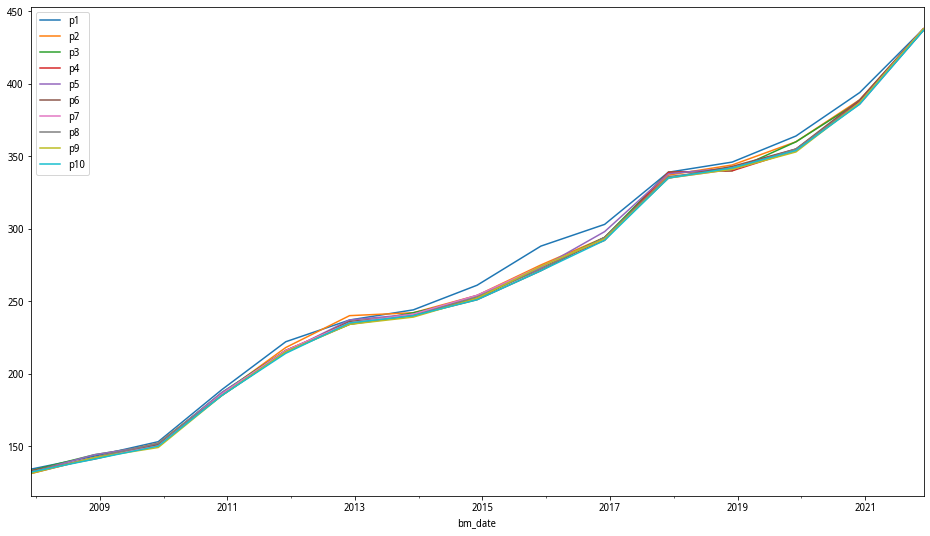

In [113]:
pf_n_stks = pd.DataFrame()
for key, value in portfolios.items():
    pf_n_stks[key] = portfolios[key].groupby('bm_date')['secID'].nunique()

display(pf_n_stks)

pf_n_stks.plot()

In [114]:
portfolios['p10'].groupby('bm_date')['mkt_cap'].mean()/1e9

bm_date
2007-12     9.520442
2008-12    24.801299
2009-12    23.330185
2010-12     7.387187
2011-12     4.310136
2012-12     6.852996
2013-12    24.818758
2014-12    30.266811
2015-12    46.521432
2016-12    49.633862
2017-12    25.116625
2018-12    23.554655
2019-12    25.433189
2020-12    27.416370
2021-12    23.515428
Freq: M, Name: mkt_cap, dtype: float64

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
bm_date,,,,,,,,,,
2007-12,5.715808e+09,4.795101e+09,2.882950e+09,3.434211e+09,3.840968e+09,3.304378e+09,2.571075e+09,2.325255e+09,1.692608e+09,9.520442e+09
2008-12,8.177124e+09,9.130319e+09,7.149702e+09,6.599234e+09,7.352643e+09,5.789497e+09,5.991050e+09,5.301314e+09,7.721629e+09,2.480130e+10
2009-12,1.067969e+10,8.379840e+09,7.375834e+09,8.714215e+09,9.299599e+09,1.347153e+10,1.388075e+10,1.177886e+10,4.367188e+09,2.333018e+10
2010-12,9.788895e+09,6.836670e+09,5.396383e+09,5.858096e+09,5.716337e+09,1.145075e+10,1.965841e+10,1.488090e+10,7.589464e+09,7.387187e+09
2011-12,8.593670e+09,5.343388e+09,5.859148e+09,8.330202e+09,1.316118e+10,8.513601e+09,1.432788e+10,7.445566e+09,3.744470e+09,4.310136e+09
2012-12,7.913350e+09,7.126788e+09,5.878258e+09,6.422015e+09,8.262964e+09,1.419814e+10,1.351916e+10,4.738759e+09,6.146973e+09,6.852996e+09
2013-12,1.039635e+10,9.947602e+09,8.807784e+09,8.933609e+09,9.016754e+09,7.248690e+09,1.388587e+10,1.694208e+10,1.861084e+10,2.481876e+10
2014-12,1.116183e+10,1.250609e+10,1.256581e+10,1.090602e+10,1.280498e+10,1.061681e+10,1.042628e+10,1.919891e+10,1.367151e+10,3.026681e+10
2015-12,9.341924e+09,9.016056e+09,1.004300e+10,9.985461e+09,9.288530e+09,1.068221e+10,1.002104e+10,1.043531e+10,1.542386e+10,4.652143e+10


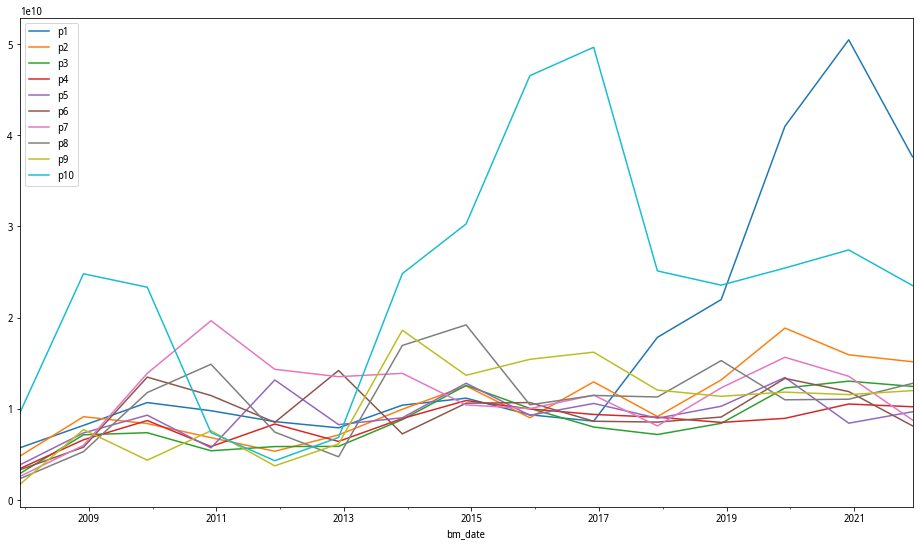

In [115]:
pf_mktcap = pd.DataFrame()
for key, value in portfolios.items():
    pf_mktcap[key] = portfolios[key].groupby('bm_date')['mkt_cap'].mean()

display(pf_mktcap)

pf_mktcap.plot()

In [116]:
pf_mktcap = pf_mktcap / 1e10
for i in range(10):
    print(pf_mktcap.mean()[i])

1.7285225763373466
1.0551583098923218
0.8486621563464765
0.8389765772572633
0.934024016924777
0.9659718376251994
1.1611995866399725
1.1060784470939953
1.0264631375974875
2.349862499307394


## BM 1年调仓单排结论

排序方法：t年7月至t+1年6月，按照t-1年12月的BM排序，考察区间内每月平均收益率以及区间年平均收益率

结论：
- 月、年平均收益率呈现微弱递增，但p10的收益率较差。年收益的显著性比较强。
- 最大BM组（也即估值最低组）的market cap起伏很大
- 最小BM组（也即估值最高组）的market cap在样本后期显著增大
- BM的效应可能和market cap有关系

## BM Point-in-Time

In [117]:
del portfolios, portfolios_crs_mean

In [118]:
# fundmen_df = DataAPI.FdmtBSGet(secID=stk_id,beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

# fundmen_df.to_pickle('./data/fundmen_df_pit.pkl')

In [119]:
fundmen_df = pd.read_pickle('./data/fundmen_df_pit.pkl')

In [120]:
fundmen_df[['publishDate','endDate']] = fundmen_df[['publishDate','endDate']].apply(pd.to_datetime)

In [121]:
fundmen_df.sort_values(['secID','publishDate','endDate'],inplace=True)

In [122]:
fundmen_df

,secID,publishDate,endDate,endDateRep,actPubtime,fiscalPeriod,TShEquity,TEquityAttrP,minorityInt
121,000001.XSHE,2007-04-26,2007-03-31,2007-03-31,2007-04-25 18:00:00,3,7.106094e+09,7.106094e+09,NaN
120,000001.XSHE,2007-08-16,2007-06-30,2007-06-30,2007-08-15 18:00:00,6,7.698478e+09,7.698478e+09,NaN
119,000001.XSHE,2007-10-23,2007-09-30,2007-09-30,2007-10-22 18:00:00,9,8.363553e+09,8.363553e+09,NaN
118,000001.XSHE,2008-03-20,2007-12-31,2007-12-31,2008-03-19 18:00:00,12,1.300606e+10,1.300606e+10,NaN
117,000001.XSHE,2008-04-24,2007-12-31,2008-03-31,2008-04-23 18:00:00,12,1.300606e+10,1.300606e+10,NaN
113,000001.XSHE,2008-04-24,2008-03-31,2008-03-31,2008-04-23 18:00:00,3,1.404138e+10,1.404138e+10,NaN
116,000001.XSHE,2008-08-21,2007-12-31,2008-06-30,2008-08-20 18:00:00,12,1.300606e+10,1.300606e+10,NaN
112,000001.XSHE,2008-08-21,2008-06-30,2008-06-30,2008-08-20 18:00:00,6,1.694330e+10,1.694330e+10,NaN
...,...,...,...,...,...,...,...,...,...
433177,900957.XSHG,2022-04-20,2020-12-31,2021-12-31,2022-04-19 17:15:56,12,4.987276e+08,4.979110e+08,816555.06


In [123]:
fundmen_df.sort_values(['secID','publishDate'])

,secID,publishDate,endDate,endDateRep,actPubtime,fiscalPeriod,TShEquity,TEquityAttrP,minorityInt
121,000001.XSHE,2007-04-26,2007-03-31,2007-03-31,2007-04-25 18:00:00,3,7.106094e+09,7.106094e+09,NaN
120,000001.XSHE,2007-08-16,2007-06-30,2007-06-30,2007-08-15 18:00:00,6,7.698478e+09,7.698478e+09,NaN
119,000001.XSHE,2007-10-23,2007-09-30,2007-09-30,2007-10-22 18:00:00,9,8.363553e+09,8.363553e+09,NaN
118,000001.XSHE,2008-03-20,2007-12-31,2007-12-31,2008-03-19 18:00:00,12,1.300606e+10,1.300606e+10,NaN
117,000001.XSHE,2008-04-24,2007-12-31,2008-03-31,2008-04-23 18:00:00,12,1.300606e+10,1.300606e+10,NaN
113,000001.XSHE,2008-04-24,2008-03-31,2008-03-31,2008-04-23 18:00:00,3,1.404138e+10,1.404138e+10,NaN
116,000001.XSHE,2008-08-21,2007-12-31,2008-06-30,2008-08-20 18:00:00,12,1.300606e+10,1.300606e+10,NaN
112,000001.XSHE,2008-08-21,2008-06-30,2008-06-30,2008-08-20 18:00:00,6,1.694330e+10,1.694330e+10,NaN
...,...,...,...,...,...,...,...,...,...
433177,900957.XSHG,2022-04-20,2020-12-31,2021-12-31,2022-04-19 17:15:56,12,4.987276e+08,4.979110e+08,816555.06


In [124]:
fundmen_df = fundmen_df.groupby(['secID','publishDate'],as_index=False).last() #不涉及上上个报表的信息

In [125]:
fundmen_df

,secID,publishDate,endDate,endDateRep,actPubtime,fiscalPeriod,TShEquity,TEquityAttrP,minorityInt
0,000001.XSHE,2007-04-26,2007-03-31,2007-03-31,2007-04-25 18:00:00,3,7.106094e+09,7.106094e+09,NaN
1,000001.XSHE,2007-08-16,2007-06-30,2007-06-30,2007-08-15 18:00:00,6,7.698478e+09,7.698478e+09,NaN
2,000001.XSHE,2007-10-23,2007-09-30,2007-09-30,2007-10-22 18:00:00,9,8.363553e+09,8.363553e+09,NaN
3,000001.XSHE,2008-03-20,2007-12-31,2007-12-31,2008-03-19 18:00:00,12,1.300606e+10,1.300606e+10,NaN
4,000001.XSHE,2008-04-24,2008-03-31,2008-03-31,2008-04-23 18:00:00,3,1.404138e+10,1.404138e+10,NaN
5,000001.XSHE,2008-08-21,2008-06-30,2008-06-30,2008-08-20 18:00:00,6,1.694330e+10,1.694330e+10,NaN
6,000001.XSHE,2008-10-24,2008-09-30,2008-09-30,2008-10-23 18:00:00,9,1.837466e+10,1.837466e+10,NaN
7,000001.XSHE,2009-03-20,2008-12-31,2008-12-31,2009-03-19 18:00:00,12,1.640079e+10,1.640079e+10,NaN
...,...,...,...,...,...,...,...,...,...
195857,900957.XSHG,2021-04-09,2020-12-31,2020-12-31,2021-04-08 18:13:16,12,4.987276e+08,4.979110e+08,816555.06


In [126]:
fundmen_df = fundmen_df[(fundmen_df['secID'].str.endswith('XSHE')) | (fundmen_df['secID'].str.endswith('XSHG'))]

In [127]:
# # minorityInt 有时报告，有时不报告。空值时，假设就是上一次报告的值
# # fundmen_df['minorityInt'] = fundmen_df.groupby('secID')['minorityInt'].fillna(method='ffill')
# # 第一轮填完空值为有效数值后，剩下的空值再用0填充。
# fundmen_df['minorityInt'].fillna(0,inplace=True)

- 假设是上一次报告的值可能出现误差，因为股权变动了（注意ffill的方法）
- 直接用TEquityAttrP

In [128]:
# fundmen_df['book'] = fundmen_df['TShEquity'] - fundmen_df['minorityInt']
fundmen_df['book'] = fundmen_df['TEquityAttrP']

In [129]:
fundmen_df

,secID,publishDate,endDate,endDateRep,actPubtime,fiscalPeriod,TShEquity,TEquityAttrP,minorityInt,book
0,000001.XSHE,2007-04-26,2007-03-31,2007-03-31,2007-04-25 18:00:00,3,7.106094e+09,7.106094e+09,NaN,7.106094e+09
1,000001.XSHE,2007-08-16,2007-06-30,2007-06-30,2007-08-15 18:00:00,6,7.698478e+09,7.698478e+09,NaN,7.698478e+09
2,000001.XSHE,2007-10-23,2007-09-30,2007-09-30,2007-10-22 18:00:00,9,8.363553e+09,8.363553e+09,NaN,8.363553e+09
3,000001.XSHE,2008-03-20,2007-12-31,2007-12-31,2008-03-19 18:00:00,12,1.300606e+10,1.300606e+10,NaN,1.300606e+10
4,000001.XSHE,2008-04-24,2008-03-31,2008-03-31,2008-04-23 18:00:00,3,1.404138e+10,1.404138e+10,NaN,1.404138e+10
5,000001.XSHE,2008-08-21,2008-06-30,2008-06-30,2008-08-20 18:00:00,6,1.694330e+10,1.694330e+10,NaN,1.694330e+10
6,000001.XSHE,2008-10-24,2008-09-30,2008-09-30,2008-10-23 18:00:00,9,1.837466e+10,1.837466e+10,NaN,1.837466e+10
7,000001.XSHE,2009-03-20,2008-12-31,2008-12-31,2009-03-19 18:00:00,12,1.640079e+10,1.640079e+10,NaN,1.640079e+10
...,...,...,...,...,...,...,...,...,...,...
195857,900957.XSHG,2021-04-09,2020-12-31,2020-12-31,2021-04-08 18:13:16,12,4.987276e+08,4.979110e+08,816555.06,4.979110e+08


- ~~考虑到报表公布时间可能在当天收市以后，以及报表解读可能需要时间，把publishDate往后加1~~
- publishDate和 tradeDate merge, 
- publishDate可能是非交易日，所以merge时要outer，左右表格都不丢观测值。
- 接着要把tradeDate为空值的设置为publishDate，便于排序，方便下面填充
- 然后按照secID和tradeDate sort，因为publishDate非交易日的被放到merge表格的最后了。
- 接着 book 空值由上面第一个非空值填充（当时已知的最新的book value）
- 再把 na 都丢弃即可

In [130]:
# fundmen_df['publishDate+1'] = fundmen_df['publishDate'] + dt.timedelta(days=1)

In [131]:
stk_fundmen_df = pd.merge(stk_df, fundmen_df[['secID','publishDate','endDate','book']], 
                          left_on=['secID','tradeDate'], right_on=['secID','publishDate'],
                          how='outer')

In [132]:
stk_fundmen_df

,secID,tradeDate,closePrice,negMarketValue,ym,publishDate,endDate,book
0,000001.XSHE,2007-06-20,987.007,4.835036e+10,2007-06,NaT,NaT,NaN
1,000001.XSHE,2007-06-21,1085.740,5.318694e+10,2007-06,NaT,NaT,NaN
2,000001.XSHE,2007-06-22,1120.233,5.487665e+10,2007-06,NaT,NaT,NaN
3,000001.XSHE,2007-06-25,1113.904,5.456661e+10,2007-06,NaT,NaT,NaN
4,000001.XSHE,2007-06-26,1113.904,5.456661e+10,2007-06,NaT,NaT,NaN
5,000001.XSHE,2007-06-27,1019.602,4.994705e+10,2007-06,NaT,NaT,NaN
6,000001.XSHE,2007-06-28,953.780,4.672266e+10,2007-06,NaT,NaT,NaN
7,000001.XSHE,2007-06-29,870.870,4.266117e+10,2007-06,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...
11105027,900957.XSHG,NaT,NaN,NaN,NaT,2015-08-15,2015-06-30,3.952715e+08


In [133]:
idx = stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna()].index

In [134]:
stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna(),'tradeDate'] = stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna(),'publishDate']

In [135]:
stk_fundmen_df.loc[idx]

,secID,tradeDate,closePrice,negMarketValue,ym,publishDate,endDate,book
11048078,000001.XSHE,2007-04-26,NaN,NaN,NaT,2007-04-26,2007-03-31,7.106094e+09
11048079,000001.XSHE,2017-04-22,NaN,NaN,NaT,2017-04-22,2017-03-31,2.077390e+11
11048080,000001.XSHE,2017-10-21,NaN,NaN,NaT,2017-10-21,2017-09-30,2.181110e+11
11048081,000002.XSHE,2022-10-29,NaN,NaN,NaT,2022-10-29,2022-09-30,2.411070e+11
11048082,000003.XSHE,2008-04-30,NaN,NaN,NaT,2008-04-30,2007-12-31,-2.889290e+09
11048083,000003.XSHE,2008-08-29,NaN,NaN,NaT,2008-08-29,2008-06-30,-2.872336e+09
11048084,000003.XSHE,2009-04-30,NaN,NaN,NaT,2009-04-30,2008-12-31,-2.983208e+09
11048085,000003.XSHE,2009-08-28,NaN,NaN,NaT,2009-08-28,2009-06-30,-2.964330e+09
...,...,...,...,...,...,...,...,...
11105027,900957.XSHG,2015-08-15,NaN,NaN,NaT,2015-08-15,2015-06-30,3.952715e+08


In [136]:
stk_fundmen_df

,secID,tradeDate,closePrice,negMarketValue,ym,publishDate,endDate,book
0,000001.XSHE,2007-06-20,987.007,4.835036e+10,2007-06,NaT,NaT,NaN
1,000001.XSHE,2007-06-21,1085.740,5.318694e+10,2007-06,NaT,NaT,NaN
2,000001.XSHE,2007-06-22,1120.233,5.487665e+10,2007-06,NaT,NaT,NaN
3,000001.XSHE,2007-06-25,1113.904,5.456661e+10,2007-06,NaT,NaT,NaN
4,000001.XSHE,2007-06-26,1113.904,5.456661e+10,2007-06,NaT,NaT,NaN
5,000001.XSHE,2007-06-27,1019.602,4.994705e+10,2007-06,NaT,NaT,NaN
6,000001.XSHE,2007-06-28,953.780,4.672266e+10,2007-06,NaT,NaT,NaN
7,000001.XSHE,2007-06-29,870.870,4.266117e+10,2007-06,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...
11105027,900957.XSHG,2015-08-15,NaN,NaN,NaT,2015-08-15,2015-06-30,3.952715e+08


In [137]:
stk_fundmen_df.sort_values(['secID','tradeDate'],inplace=True)

In [138]:
stk_fundmen_df

,secID,tradeDate,closePrice,negMarketValue,ym,publishDate,endDate,book
11048078,000001.XSHE,2007-04-26,NaN,NaN,NaT,2007-04-26,2007-03-31,7.106094e+09
0,000001.XSHE,2007-06-20,987.007,4.835036e+10,2007-06,NaT,NaT,NaN
1,000001.XSHE,2007-06-21,1085.740,5.318694e+10,2007-06,NaT,NaT,NaN
2,000001.XSHE,2007-06-22,1120.233,5.487665e+10,2007-06,NaT,NaT,NaN
3,000001.XSHE,2007-06-25,1113.904,5.456661e+10,2007-06,NaT,NaT,NaN
4,000001.XSHE,2007-06-26,1113.904,5.456661e+10,2007-06,NaT,NaT,NaN
5,000001.XSHE,2007-06-27,1019.602,4.994705e+10,2007-06,NaT,NaT,NaN
6,000001.XSHE,2007-06-28,953.780,4.672266e+10,2007-06,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...
11048070,900957.XSHG,2023-02-22,0.577,1.052480e+08,2023-02,NaT,NaT,NaN


In [139]:
temp = stk_fundmen_df[stk_fundmen_df['secID']=='000001.XSHE'].copy()
temp

,secID,tradeDate,closePrice,negMarketValue,ym,publishDate,endDate,book
11048078,000001.XSHE,2007-04-26,NaN,NaN,NaT,2007-04-26,2007-03-31,7.106094e+09
0,000001.XSHE,2007-06-20,987.007,4.835036e+10,2007-06,NaT,NaT,NaN
1,000001.XSHE,2007-06-21,1085.740,5.318694e+10,2007-06,NaT,NaT,NaN
2,000001.XSHE,2007-06-22,1120.233,5.487665e+10,2007-06,NaT,NaT,NaN
3,000001.XSHE,2007-06-25,1113.904,5.456661e+10,2007-06,NaT,NaT,NaN
4,000001.XSHE,2007-06-26,1113.904,5.456661e+10,2007-06,NaT,NaT,NaN
5,000001.XSHE,2007-06-27,1019.602,4.994705e+10,2007-06,NaT,NaT,NaN
6,000001.XSHE,2007-06-28,953.780,4.672266e+10,2007-06,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...
3813,000001.XSHE,2023-02-22,1834.143,2.720658e+11,2023-02,NaT,NaT,NaN


In [140]:
temp[~temp['book'].isna()]

,secID,tradeDate,closePrice,negMarketValue,ym,publishDate,endDate,book
11048078,000001.XSHE,2007-04-26,NaN,NaN,NaT,2007-04-26,2007-03-31,7.106094e+09
41,000001.XSHE,2007-08-16,1147.131,5.619431e+10,2007-08,2007-08-16,2007-06-30,7.698478e+09
84,000001.XSHE,2007-10-23,1300.609,6.371272e+10,2007-10,2007-10-23,2007-09-30,8.363553e+09
184,000001.XSHE,2008-03-20,917.705,5.094780e+10,2008-03,2008-03-20,2007-12-31,1.300606e+10
208,000001.XSHE,2008-04-24,869.921,4.829500e+10,2008-04,2008-04-24,2008-03-31,1.404138e+10
290,000001.XSHE,2008-08-21,639.545,4.328991e+10,2008-08,2008-08-21,2008-06-30,1.694330e+10
330,000001.XSHE,2008-10-24,380.689,2.576831e+10,2008-10,2008-10-24,2008-09-30,1.837466e+10
428,000001.XSHE,2009-03-20,632.527,4.268801e+10,2009-03,2009-03-20,2008-12-31,1.640079e+10
...,...,...,...,...,...,...,...,...
3318,000001.XSHE,2021-02-02,2968.848,4.517660e+11,2021-02,2021-02-02,2020-12-31,3.641310e+11


In [141]:
stk_fundmen_df[['secID','publishDate','endDate','book']].groupby('secID').fillna(method='ffill')

,publishDate,endDate,book
11048078,2007-04-26,2007-03-31,7.106094e+09
0,2007-04-26,2007-03-31,7.106094e+09
1,2007-04-26,2007-03-31,7.106094e+09
2,2007-04-26,2007-03-31,7.106094e+09
3,2007-04-26,2007-03-31,7.106094e+09
4,2007-04-26,2007-03-31,7.106094e+09
5,2007-04-26,2007-03-31,7.106094e+09
6,2007-04-26,2007-03-31,7.106094e+09
...,...,...,...
11048070,2022-10-28,2022-09-30,5.558669e+08


In [142]:
stk_fundmen_df.loc[:,['publishDate','endDate','book']] = stk_fundmen_df[['secID','publishDate','endDate','book']].groupby('secID').fillna(method='ffill')

In [143]:
## 查看数据
idx = pd.IndexSlice
stk_fundmen_df.set_index(['secID','tradeDate'],inplace=True)
pd.options.display.max_rows = 20

In [144]:
stk_fundmen_df.loc[idx['000001.XSHE','2010-03'],:]

closePrice  negMarketValue       ym publishDate  \
secID       tradeDate                                                     
000001.XSHE 2010-03-01     926.303    6.564637e+10  2010-03  2009-10-29   
            2010-03-02     953.535    6.757628e+10  2010-03  2009-10-29   
            2010-03-03     961.374    6.813186e+10  2010-03  2009-10-29   
            2010-03-04     953.122    6.754704e+10  2010-03  2009-10-29   
            2010-03-05     960.137    6.804414e+10  2010-03  2009-10-29   
            2010-03-08     984.068    6.974013e+10  2010-03  2009-10-29   
            2010-03-09     982.830    6.965240e+10  2010-03  2009-10-29   
            2010-03-10     965.500    6.842427e+10  2010-03  2009-10-29   
            2010-03-11     976.228    6.918454e+10  2010-03  2009-10-29   
            2010-03-12     945.695    6.702070e+10  2010-03  2010-03-12   
...                            ...             ...      ...         ...   
            2010-03-18     951.059    6.740083e+10  2010-03  2010-03-12   
            2010-03-19     950.647    6.737159e+10  2010-03  2010-03-12   
            2010-03-22     955.185    6.769325e+10  2010-03  2010-03-12   
            2010-03-23     941.982    6.675753e+10  2010-03  2010-03-12   
            2010-03-24     940.744    6.666981e+10  2010-03  2010-03-12   
            2010-03-25     920.114    6.520775e+10  2010-03  2010-03-12   
            2010-03-26     941.157    6.669905e+10  2010-03  2010-03-12   
            2010-03-29     972.102    6.889213e+10  2010-03  2010-03-12   
            2010-03-30     975.816    6.915530e+10  2010-03  2010-03-12   
            2010-03-31     957.248    6.783945e+10  2010-03  2010-03-12   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2010-03-01 2009-09-30  1.908844e+10  
            2010-03-02 2009-09-30  1.908844e+10  
            2010-03-03 2009-09-30  1.908844e+10  
            2010-03-04 2009-09-30  1.908844e+10  
            2010-03-05 2009-09-30  1.908844e+10  
            2010-03-08 2009-09-30  1.908844e+10  
            2010-03-09 2009-09-30  1.908844e+10  
            2010-03-10 2009-09-30  1.908844e+10  
            2010-03-11 2009-09-30  1.908844e+10  
            2010-03-12 2009-12-31  2.046961e+10  
...                           ...           ...  
            2010-03-18 2009-12-31  2.046961e+10  
            2010-03-19 2009-12-31  2.046961e+10  
            2010-03-22 2009-12-31  2.046961e+10  
            2010-03-23 2009-12-31  2.046961e+10  
            2010-03-24 2009-12-31  2.046961e+10  
            2010-03-25 2009-12-31  2.046961e+10  
            2010-03-26 2009-12-31  2.046961e+10  
            2010-03-29 2009-12-31  2.046961e+10  
            2010-03-30 2009-12-31  2.046961e+10  
            2010-03-31 2009-12-31  2.046961e+10  

[23 rows x 6 columns]

In [145]:
stk_fundmen_df.loc[idx['000001.XSHE','2007-04'],:]

,,closePrice,negMarketValue,ym,publishDate,endDate,book
secID,tradeDate,,,,,,
000001.XSHE,2007-04-26,NaN,NaN,NaT,2007-04-26,2007-03-31,7.106094e+09


In [146]:
stk_fundmen_df.loc[idx['000001.XSHE','2007-04':'2007-06'],:]

closePrice  negMarketValue       ym publishDate  \
secID       tradeDate                                                     
000001.XSHE 2007-04-26         NaN             NaN      NaT  2007-04-26   
            2007-06-20     987.007    4.835036e+10  2007-06  2007-04-26   
            2007-06-21    1085.740    5.318694e+10  2007-06  2007-04-26   
            2007-06-22    1120.233    5.487665e+10  2007-06  2007-04-26   
            2007-06-25    1113.904    5.456661e+10  2007-06  2007-04-26   
            2007-06-26    1113.904    5.456661e+10  2007-06  2007-04-26   
            2007-06-27    1019.602    4.994705e+10  2007-06  2007-04-26   
            2007-06-28     953.780    4.672266e+10  2007-06  2007-04-26   
            2007-06-29     870.870    4.266117e+10  2007-06  2007-04-26   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2007-04-26 2007-03-31  7.106094e+09  
            2007-06-20 2007-03-31  7.106094e+09  
            2007-06-21 2007-03-31  7.106094e+09  
            2007-06-22 2007-03-31  7.106094e+09  
            2007-06-25 2007-03-31  7.106094e+09  
            2007-06-26 2007-03-31  7.106094e+09  
            2007-06-27 2007-03-31  7.106094e+09  
            2007-06-28 2007-03-31  7.106094e+09  
            2007-06-29 2007-03-31  7.106094e+09

In [147]:
stk_fundmen_df.reset_index(inplace=True)

In [148]:
stk_fundmen_df

,secID,tradeDate,closePrice,negMarketValue,ym,publishDate,endDate,book
0,000001.XSHE,2007-04-26,NaN,NaN,NaT,2007-04-26,2007-03-31,7.106094e+09
1,000001.XSHE,2007-06-20,987.007,4.835036e+10,2007-06,2007-04-26,2007-03-31,7.106094e+09
2,000001.XSHE,2007-06-21,1085.740,5.318694e+10,2007-06,2007-04-26,2007-03-31,7.106094e+09
3,000001.XSHE,2007-06-22,1120.233,5.487665e+10,2007-06,2007-04-26,2007-03-31,7.106094e+09
4,000001.XSHE,2007-06-25,1113.904,5.456661e+10,2007-06,2007-04-26,2007-03-31,7.106094e+09
5,000001.XSHE,2007-06-26,1113.904,5.456661e+10,2007-06,2007-04-26,2007-03-31,7.106094e+09
6,000001.XSHE,2007-06-27,1019.602,4.994705e+10,2007-06,2007-04-26,2007-03-31,7.106094e+09
7,000001.XSHE,2007-06-28,953.780,4.672266e+10,2007-06,2007-04-26,2007-03-31,7.106094e+09
8,000001.XSHE,2007-06-29,870.870,4.266117e+10,2007-06,2007-04-26,2007-03-31,7.106094e+09
9,000001.XSHE,2007-07-02,867.073,4.247515e+10,2007-07,2007-04-26,2007-03-31,7.106094e+09


In [149]:
stk_df_m = stk_fundmen_df.groupby(['secID','ym'],as_index=False).last()

stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

In [150]:
stk_df_m

,secID,ym,tradeDate,closePrice,negMarketValue,publishDate,endDate,book,ret
0,000001.XSHE,2007-06,2007-06-29,870.870,4.266117e+10,2007-04-26,2007-03-31,7.106094e+09,NaN
1,000001.XSHE,2007-07,2007-07-31,1146.498,5.616330e+10,2007-04-26,2007-03-31,7.106094e+09,0.316497
2,000001.XSHE,2007-08,2007-08-31,1202.510,5.890714e+10,2007-08-16,2007-06-30,7.698478e+09,0.048855
3,000001.XSHE,2007-09,2007-09-28,1265.167,6.197651e+10,2007-08-16,2007-06-30,7.698478e+09,0.052105
4,000001.XSHE,2007-10,2007-10-31,1520.542,7.448652e+10,2007-10-23,2007-09-30,8.363553e+09,0.201851
5,000001.XSHE,2007-11,2007-11-30,1141.751,5.593078e+10,2007-10-23,2007-09-30,8.363553e+09,-0.249116
6,000001.XSHE,2007-12,2007-12-28,1221.497,6.574629e+10,2007-10-23,2007-09-30,8.363553e+09,0.069845
7,000001.XSHE,2008-01,2008-01-31,1053.778,5.850212e+10,2007-10-23,2007-09-30,8.363553e+09,-0.137306
8,000001.XSHE,2008-02,2008-02-29,1049.032,5.823860e+10,2007-10-23,2007-09-30,8.363553e+09,-0.004504
9,000001.XSHE,2008-03,2008-03-31,892.389,4.954234e+10,2008-03-20,2007-12-31,1.300606e+10,-0.149321


In [151]:
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

In [152]:
stk_df_m

,secID,ym,tradeDate,closePrice,negMarketValue,publishDate,endDate,book,ret,ret_date
0,000001.XSHE,2007-06,2007-06-29,870.870,4.266117e+10,2007-04-26,2007-03-31,7.106094e+09,0.316497,2007-07
1,000001.XSHE,2007-07,2007-07-31,1146.498,5.616330e+10,2007-04-26,2007-03-31,7.106094e+09,0.048855,2007-08
2,000001.XSHE,2007-08,2007-08-31,1202.510,5.890714e+10,2007-08-16,2007-06-30,7.698478e+09,0.052105,2007-09
3,000001.XSHE,2007-09,2007-09-28,1265.167,6.197651e+10,2007-08-16,2007-06-30,7.698478e+09,0.201851,2007-10
4,000001.XSHE,2007-10,2007-10-31,1520.542,7.448652e+10,2007-10-23,2007-09-30,8.363553e+09,-0.249116,2007-11
5,000001.XSHE,2007-11,2007-11-30,1141.751,5.593078e+10,2007-10-23,2007-09-30,8.363553e+09,0.069845,2007-12
6,000001.XSHE,2007-12,2007-12-28,1221.497,6.574629e+10,2007-10-23,2007-09-30,8.363553e+09,-0.137306,2008-01
7,000001.XSHE,2008-01,2008-01-31,1053.778,5.850212e+10,2007-10-23,2007-09-30,8.363553e+09,-0.004504,2008-02
8,000001.XSHE,2008-02,2008-02-29,1049.032,5.823860e+10,2007-10-23,2007-09-30,8.363553e+09,-0.149321,2008-03
9,000001.XSHE,2008-03,2008-03-31,892.389,4.954234e+10,2008-03-20,2007-12-31,1.300606e+10,0.050355,2008-04


In [153]:
stk_df_m['ym_diff'] = stk_df_m['ret_date'].astype(int) - stk_df_m['ym'].astype(int)
stk_df_m.loc[stk_df_m['ym_diff'] != 1]

,secID,ym,tradeDate,closePrice,negMarketValue,publishDate,endDate,book,ret,ret_date,ym_diff
189,000001.XSHE,2023-03,2023-03-03,1869.466,2.773053e+11,2022-10-25,2022-09-30,4.253840e+11,NaN,NaT,9223372036854775170
384,000002.XSHE,2023-03,2023-03-03,2656.185,1.633521e+11,2022-10-29,2022-09-30,2.411070e+11,NaN,NaT,9223372036854775170
516,000004.XSHE,2022-05,2022-05-05,85.971,1.463441e+09,2022-04-30,2022-03-31,9.351158e+08,NaN,NaT,9223372036854775180
671,000005.XSHE,2021-04,2021-04-30,21.814,2.348641e+09,2021-04-30,2021-03-31,1.248325e+09,NaN,NaT,9223372036854775193
866,000006.XSHE,2023-03,2023-03-03,417.729,7.924471e+09,2022-10-28,2022-09-30,7.683314e+09,NaN,NaT,9223372036854775170
870,000007.XSHE,2007-04,2007-04-20,48.203,7.268053e+08,NaT,NaT,NaN,1.612327,2012-05,61
978,000007.XSHE,2021-04,2021-04-29,47.401,1.217255e+09,2021-04-29,2021-03-31,6.318241e+07,0.870572,2022-07,15
987,000007.XSHE,2023-03,2023-03-03,93.359,2.397436e+09,2022-10-26,2022-09-30,9.238106e+07,NaN,NaT,9223372036854775170
990,000008.XSHE,2007-03,2007-03-29,22.937,3.197319e+08,NaT,NaT,NaN,0.814579,2013-04,73
1110,000008.XSHE,2023-03,2023-03-03,69.660,6.811892e+09,2022-10-29,2022-09-30,5.032390e+09,NaN,NaT,9223372036854775170


In [154]:
# 停牌删去
stk_df_m['ym_diff'] = stk_df_m['ret_date'].astype(int) - stk_df_m['ym'].astype(int)
stk_df_m.loc[stk_df_m['ym_diff'] != 1,'ret'] = np.nan

In [155]:
# 查看数据
temp = stk_df_m['secID'].unique()
display(stk_df_m[stk_df_m['secID'] == np.random.choice(temp,1)[0]])

,secID,ym,tradeDate,closePrice,negMarketValue,publishDate,endDate,book,ret,ret_date,ym_diff
68321,000901.XSHE,2007-01,2007-01-31,19.923,5.894784e+08,NaT,NaT,NaN,0.158862,2007-02,1
68322,000901.XSHE,2007-02,2007-02-28,23.088,6.831014e+08,NaT,NaT,NaN,0.352781,2007-03,1
68323,000901.XSHE,2007-03,2007-03-30,31.233,9.240941e+08,NaT,NaT,NaN,0.163225,2007-04,1
68324,000901.XSHE,2007-04,2007-04-30,36.331,2.032149e+09,2007-04-25,2007-03-31,3.653547e+08,0.047590,2007-05,1
68325,000901.XSHE,2007-05,2007-05-31,38.060,2.128840e+09,2007-04-25,2007-03-31,3.653547e+08,-0.331792,2007-06,1
68326,000901.XSHE,2007-06,2007-06-29,25.432,1.422504e+09,2007-04-25,2007-03-31,3.653547e+08,0.165893,2007-07,1
68327,000901.XSHE,2007-07,2007-07-31,29.651,1.658495e+09,2007-04-25,2007-03-31,3.653547e+08,0.385350,2007-08,1
68328,000901.XSHE,2007-08,2007-08-31,41.077,2.297639e+09,2007-08-07,2007-06-30,3.506422e+08,0.087738,2007-09,1
68329,000901.XSHE,2007-09,2007-09-28,44.681,2.499215e+09,2007-08-07,2007-06-30,3.506422e+08,-0.277366,2007-10,1
68330,000901.XSHE,2007-10,2007-10-31,32.288,1.805990e+09,2007-10-30,2007-09-30,3.540876e+08,0.155166,2007-11,1


In [156]:
del temp

In [157]:
stk_df_m.drop(['tradeDate','closePrice','publishDate','endDate', 'ym_diff'],axis=1,inplace=True)

stk_df_m.rename(columns={'ym':'mktcap_book_date','negMarketValue':'mktcap'},inplace=True)

stk_df_m.dropna(inplace=True)

stk_df_m

,secID,mktcap_book_date,mktcap,book,ret,ret_date
0,000001.XSHE,2007-06,4.266117e+10,7.106094e+09,0.316497,2007-07
1,000001.XSHE,2007-07,5.616330e+10,7.106094e+09,0.048855,2007-08
2,000001.XSHE,2007-08,5.890714e+10,7.698478e+09,0.052105,2007-09
3,000001.XSHE,2007-09,6.197651e+10,7.698478e+09,0.201851,2007-10
4,000001.XSHE,2007-10,7.448652e+10,8.363553e+09,-0.249116,2007-11
5,000001.XSHE,2007-11,5.593078e+10,8.363553e+09,0.069845,2007-12
6,000001.XSHE,2007-12,6.574629e+10,8.363553e+09,-0.137306,2008-01
7,000001.XSHE,2008-01,5.850212e+10,8.363553e+09,-0.004504,2008-02
8,000001.XSHE,2008-02,5.823860e+10,8.363553e+09,-0.149321,2008-03
9,000001.XSHE,2008-03,4.954234e+10,1.300606e+10,0.050355,2008-04


### Merge

In [158]:
ret_df = pd.merge(stk_df_m, rf, left_on='ret_date',right_on='ym')
ret_df.drop('ym',axis=1,inplace=True)
ret_df['exret'] = ret_df['ret'] - ret_df['rf']
ret_df.sort_values(['secID','ret_date'],inplace=True)
ret_df.reset_index(drop=True,inplace=True)
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mktcap_book_date'],right_on=['secID','ym'])
# display(ret_df)
ret_df.drop(['ym','rf','ret'],axis=1,inplace=True)
ret_df.rename(columns={'mktcap_book_date':'grouping_date'},inplace=True)
ret_df['bm'] = ret_df['book'] / ret_df['mktcap']
ret_df['size'] = np.log(ret_df['mktcap'])
ret_df = ret_df[['secID','grouping_date','size','mktcap','bm',
                 'beta','ret_date','exret']]

In [159]:
ret_df

,secID,grouping_date,size,mktcap,bm,beta,ret_date,exret
0,000001.XSHE,2007-06,24.476555,4.266117e+10,0.166571,0.4614,2007-07,0.313877
1,000001.XSHE,2007-07,24.751529,5.616330e+10,0.126526,0.6423,2007-08,0.046173
2,000001.XSHE,2007-08,24.799228,5.890714e+10,0.130688,0.7722,2007-09,0.049171
3,000001.XSHE,2007-09,24.850021,6.197651e+10,0.124216,0.7596,2007-10,0.198601
4,000001.XSHE,2007-10,25.033884,7.448652e+10,0.112283,0.7988,2007-11,-0.252661
5,000001.XSHE,2007-11,24.747381,5.593078e+10,0.149534,0.9560,2007-12,0.066202
6,000001.XSHE,2007-12,24.909069,6.574629e+10,0.127210,0.9468,2008-01,-0.141037
7,000001.XSHE,2008-01,24.792329,5.850212e+10,0.142962,0.9654,2008-02,-0.008257
8,000001.XSHE,2008-02,24.787814,5.823860e+10,0.143608,1.0292,2008-03,-0.153072
9,000001.XSHE,2008-03,24.626093,4.954234e+10,0.262524,1.0238,2008-04,0.046610


## Sorting on BM poin-in-time

In [160]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['grouping_date'])['bm'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='grouping_date')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm']) & (ret_df_q['bm'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.002267,0.005305,0.007695,0.008414,0.010244,0.011246,0.012452,0.013310,0.014357,0.015746,0.013479
t-value,0.336678,0.789832,1.116008,1.204808,1.469645,1.600140,1.761497,1.870286,1.927962,2.008563,3.448444


结论：

- 用最新的BM更新portfolio可以带来收益率的递增，但每个portfolio本身的收益率并不显著为正，除了p10
- p10和p1的差距是显著为正的

### Sorting on BM with data from Uqer

In [161]:
# %%time
# begin_ = 2007
# yesterday = dt.datetime.today() - dt.timedelta(days=1)
# yesterday.strftime('%Y%m%d')
# pb_df = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','PB'],pandas="1")

In [162]:
# # # 从优矿下载 PB，时间较长。由于优矿的限制，每次下载3年的数据

# pb = {}
# begin_ = 2007
# end_ = 2010
# while begin_ <= 2023:
#     if begin_ == 2023:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         pb[begin_] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','PB'],pandas="1")
#     else:
#         pb[begin_] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=['secID','tradeDate','PB'],pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(pb)):
#     pb_df = pd.DataFrame(np.vstack([_df for _df in pb.values()]),columns=['secID','tradeDate','PB'])
    
# pb_df.to_pickle('./data/pb_df.pkl')

In [164]:
pb_df

,secID,tradeDate,PB
0,000001.XSHE,2007-01-04,4.5351
1,000002.XSHE,2007-01-04,6.7999
2,000004.XSHE,2007-01-04,4.2535
3,000005.XSHE,2007-01-04,2.7093
4,000006.XSHE,2007-01-04,2.8088
5,000007.XSHE,2007-01-04,6.8244
6,000008.XSHE,2007-01-04,4.2374
7,000014.XSHE,2007-01-04,2.7436
8,000016.XSHE,2007-01-04,0.7852
9,000017.XSHE,2007-01-04,-0.717


In [172]:
# pb_df = pd.read_pickle('./data/pb_df.pkl')

In [165]:
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])

pb_df['PB'] = pd.to_numeric(pb_df['PB'])

pb_df['grouping_date'] = pb_df['tradeDate'].dt.to_period('M')

pb_df = pb_df.groupby(['secID','grouping_date'],as_index=False).last()

pb_df['bm_uqer'] = 1 / pb_df['PB']

ret_df = pd.merge(ret_df,pb_df[['secID','grouping_date','bm_uqer']],on=['secID','grouping_date'])

del pb_df

In [166]:
ret_df

,secID,grouping_date,size,mktcap,bm,beta,ret_date,exret,bm_uqer
0,000001.XSHE,2007-06,24.476555,4.266117e+10,0.166571,0.4614,2007-07,0.313877,0.123739
1,000001.XSHE,2007-07,24.751529,5.616330e+10,0.126526,0.6423,2007-08,0.046173,0.093992
2,000001.XSHE,2007-08,24.799228,5.890714e+10,0.130688,0.7722,2007-09,0.049171,0.097085
3,000001.XSHE,2007-09,24.850021,6.197651e+10,0.124216,0.7596,2007-10,0.198601,0.092276
4,000001.XSHE,2007-10,25.033884,7.448652e+10,0.112283,0.7988,2007-11,-0.252661,0.083411
5,000001.XSHE,2007-11,24.747381,5.593078e+10,0.149534,0.9560,2007-12,0.066202,0.111084
6,000001.XSHE,2007-12,24.909069,6.574629e+10,0.127210,0.9468,2008-01,-0.141037,0.094476
7,000001.XSHE,2008-01,24.792329,5.850212e+10,0.142962,0.9654,2008-02,-0.008257,0.109513
8,000001.XSHE,2008-02,24.787814,5.823860e+10,0.143608,1.0292,2008-03,-0.153072,0.110009
9,000001.XSHE,2008-03,24.626093,4.954234e+10,0.262524,1.0238,2008-04,0.046610,0.201102


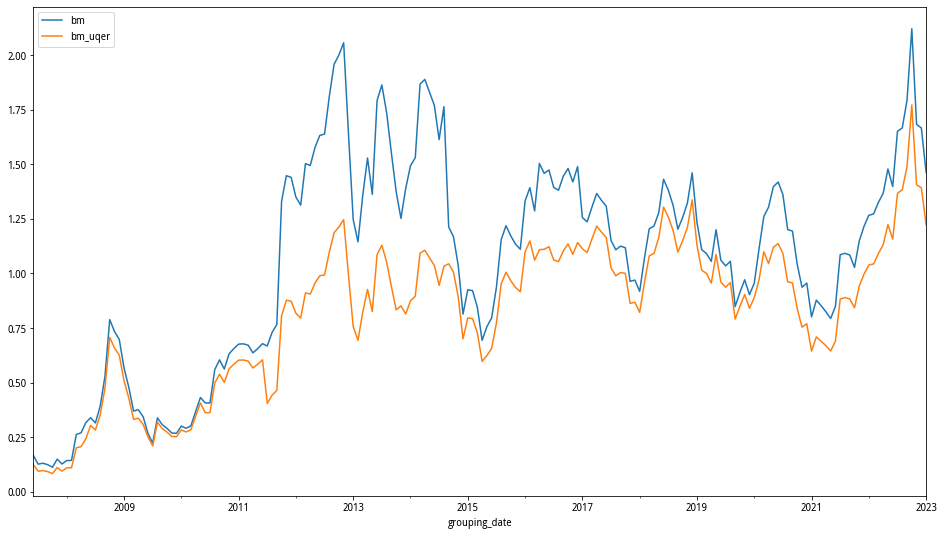

In [173]:
ret_df.loc[ret_df['secID']=='000001.XSHE',['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot()

,grouping_date,bm,bm_uqer
119475,2008-02,0.186432,0.037286
119476,2008-03,0.259620,0.051924
119477,2008-04,0.775002,0.155000
119478,2008-05,0.613057,0.153264
119479,2008-06,0.816463,0.204115
119480,2008-07,0.675406,0.168850
119481,2008-08,0.746163,0.186539
119482,2008-09,0.856908,0.214229
119483,2008-10,1.115926,0.278979
119484,2008-11,1.006362,0.251591


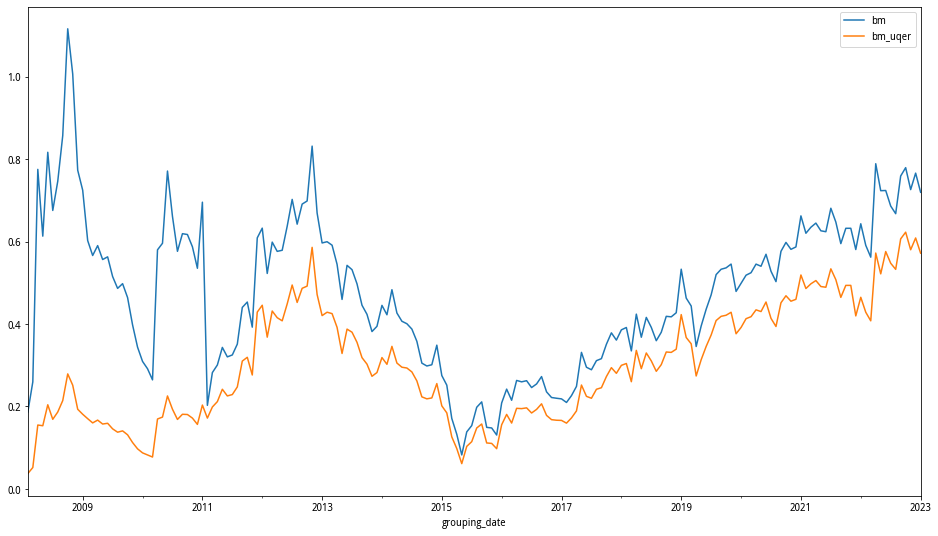

In [180]:
sample_id = np.random.choice(ret_df['secID'].unique(),1)
display(ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']])
ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ba2c54390>,
      dtype=object)

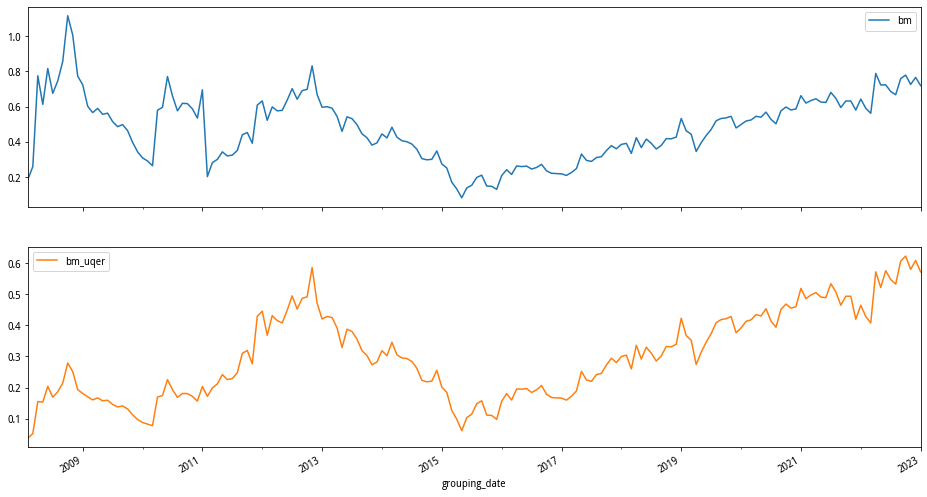

In [181]:
ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot(subplots=True)

In [182]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['grouping_date'])['bm_uqer'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='grouping_date')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm_uqer'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm_uqer']) & (ret_df_q['bm_uqer'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm_uqer'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.000930,0.007560,0.008476,0.009993,0.011839,0.012490,0.012324,0.012705,0.012921,0.011716,0.010786
t-value,0.134959,1.080074,1.152986,1.415292,1.629982,1.776933,1.725170,1.785309,1.831983,1.675358,2.872140


# Double Sorting on Size and BM

In [183]:
q_size = dict()
keys = ['q_size_1']
values = [0.5]
q_size.update(zip(keys,values))

q_bm = dict()
keys = ['q_bm_1','q_bm_2']
values = [0.3, 0.7]
q_bm.update(zip(keys,values))

q_size_df = pd.DataFrame()
for key, value in q_size.items():
    q_size_df[key] = ret_df.groupby(['grouping_date'])['size'].quantile(value)

q_bm_df = pd.DataFrame()
for key, value in q_bm.items():
    q_bm_df[key] = ret_df.groupby(['grouping_date'])['bm'].quantile(value)

ret_df_q = pd.merge(ret_df, q_size_df, on='grouping_date')
ret_df_q = pd.merge(ret_df_q, q_bm_df, on='grouping_date')

portfolios_size = dict()
portfolios_size['size1'] = ret_df_q.loc[ret_df_q['size'] <= ret_df_q['q_size_1'],
                                           ['secID','grouping_date','ret_date','exret','size','mktcap']]
portfolios_size['size2'] = ret_df_q.loc[ret_df_q['size'] >= ret_df_q['q_size_1'],
                                           ['secID','grouping_date','ret_date','exret','size','mktcap']]

portfolios_bm = dict()
portfolios_bm['bm1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q_bm_1'],
                                           ['secID','grouping_date','ret_date','exret','bm']]
portfolios_bm['bm2'] = ret_df_q.loc[(ret_df_q['bm'] >= ret_df_q['q_bm_1']) & \
                                           (ret_df_q['bm'] <= ret_df_q['q_bm_2']),
                                           ['secID','grouping_date','ret_date','exret','bm']]
portfolios_bm['bm3'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q_bm_2'],
                                           ['secID','grouping_date','ret_date','exret','bm']]

portfolios = dict()
for bm_group in portfolios_bm.keys():
    for size_group in portfolios_size.keys():
        portfolios[f'{bm_group}_{size_group}'] = pd.merge(portfolios_size[size_group],
                                                              portfolios_bm[bm_group][['secID','ret_date','bm']],
                                                              on=['secID','ret_date'])

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有bm和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['bm1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(190,)
(190,)
(190,)
(190,)
(190,)
(190,)


,bm1_size1,bm1_size2,bm2_size1,bm2_size2,bm3_size1,bm3_size2
ret_mean,0.010139,0.00216,0.015918,0.005002,0.020509,0.005087
t_values,1.389654,0.32172,2.167410,0.732416,2.547421,0.757503


# Fama MacBeth regression

In [184]:
# ret_df[(ret_df['ret_date'] >= '2008-02') & (ret_df['secID'] == '000001.XSHE')]

In [185]:
ret_df['exret100'] = ret_df['exret'] * 100

def fm_reg(df):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return None
    reg = LinearRegression().fit(y=df_.loc[:,'exret100'], X=df_.loc[:,['beta','size','bm']])
    return np.insert(reg.coef_, 0, reg.intercept_)

temp = ret_df.groupby('ret_date').apply(fm_reg)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept', 'beta_coef','size_coef', 'bm_coef']
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta_coef,size_coef,bm_coef
ret_mean,9.212739,0.405394,-0.399175,0.039288
t_values,2.619763,1.133055,-2.679284,0.714466


In [186]:
portfolios

{'bm1_size1':              secID grouping_date ret_date     exret       size        mktcap  \
 0      000014.XSHE       2007-06  2007-07  0.547459  21.108547  1.470028e+09   
 1      000025.XSHE       2007-06  2007-07 -0.201773  20.485442  7.883413e+08   
 2      000033.XSHE       2007-06  2007-07  0.126208  20.845732  1.130281e+09   
 3      000049.XSHE       2007-06  2007-07  0.471941  20.141541  5.589333e+08   
 4      000056.XSHE       2007-06  2007-07  0.156088  20.566809  8.551683e+08   
 5      000411.XSHE       2007-06  2007-07  0.430651  19.585247  3.204531e+08   
 6      000415.XSHE       2007-06  2007-07  0.165811  21.115524  1.480319e+09   
 7      000421.XSHE       2007-06  2007-07  0.146840  21.013886  1.337256e+09   
 8      000515.XSHE       2007-06  2007-07  0.252712  20.838220  1.121822e+09   
 9      000532.XSHE       2007-06  2007-07  0.321315  21.090814  1.444189e+09   
 ...            ...           ...      ...       ...        ...           ...   
 58370  600817.

# Fama French 3 factors

Fama-French 3 factors 的构建：

- Market return 就是 CAPM 里面的市场收益率
- 另外还有 SMB，HML，也即 Small-Minus-Big, High-Minus-Low

构建方法：

- mktcap1 也叫做 Small, mktcap2 Big. bm1 Low, bm2 Medium, bm3 High. 
- 因此对应的，我们的
    - bm1_mktcap1: SL
    - bm2_mktcap1: SM
    - bm3_mktcap1: SH
    - bm1_mktcap2: BL
    - bm2_mktcap2: BM
    - bm3_mktcap2: BH
- 在 Fama French (1993) 的构建里，mktcap 是在t年6月形成并保持到t+1年5月不变。bm和我们这里的构建一样，t年6月按照t-1年的BM ratio构建，保持到t+1年5月不变。
- Fama French 计算了这6组资产组合每一年从7月到下一年6月(资产形成期的第二个月的收益率)的 value-weighted excess return。weight 是t年6月的mktcap占所在portfolio 总的 mktcap 的比重。
- SMB: (SL+SM+SH)/3 - (BL+BM+BH)/3。这样构建的意思是把BM的影响平均掉。
- HML: (SH+BH)/2 - (SL+BL)/2

这里我们还是按照mktcap组合的构建日期，不改成和 Fama-French (1993) 原文一样的日期(t年6月)

In [187]:
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ret_date')['mktcap'].agg({'mktcapsum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ret_date')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcapsum']
    portfolios[pf]['weighted_exret'] = portfolios[pf]['exret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_exret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret['bm1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()
portfolios_vwret_df.rename(columns={"bm1_size1": "SL",
                                    "bm2_size1": "SM",
                                    "bm3_size1": "SH",
                                    "bm1_size2": "BL",
                                    "bm2_size2": "BM",
                                    "bm3_size2": "BH"},
                          inplace=True) # vw: value weighted

In [188]:
portfolios_vwret_df

,SL,BL,SM,BM,SH,BH
ret_date,,,,,,
2007-05,0.071362,0.111080,0.080949,0.099096,0.053438,0.082722
2007-06,-0.201392,-0.054136,-0.176249,-0.084690,-0.182697,-0.075832
2007-07,0.235563,0.186060,0.256953,0.189900,0.280729,0.192456
2007-08,0.070802,0.149930,0.102963,0.151911,0.109116,0.181585
2007-09,0.022462,0.019254,0.018286,0.042721,0.047119,0.103958
2007-10,-0.105863,-0.000321,-0.115498,-0.037586,-0.116933,0.017789
2007-11,-0.031662,-0.179535,-0.046609,-0.136686,-0.036438,-0.148290
2007-12,0.205897,0.137131,0.197296,0.165248,0.191610,0.106343
2008-01,-0.082404,-0.103462,-0.060240,-0.103317,-0.042012,-0.169955


In [189]:
SMB = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 - \
      (portfolios_vwret_df['BL'] + portfolios_vwret_df['BM'] + portfolios_vwret_df['BH']) / 3 

HML = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 - \
      (portfolios_vwret_df['SL'] + portfolios_vwret_df['BL']) / 2 

factors_df = pd.DataFrame(np.vstack([SMB,HML])).T
factors_df.columns = ['SMB','HML']
factors_df.index = SMB.index

In [190]:
factors_df

,SMB,HML
ret_date,,
2007-05,-0.029050,-0.023142
2007-06,-0.115226,-0.001500
2007-07,0.068276,0.025781
2007-08,-0.066848,0.034985
2007-09,-0.026022,0.054680
2007-10,-0.106058,0.003520
2007-11,0.116601,0.013235
2007-12,0.062027,-0.022538
2008-01,0.064026,-0.013051


百度百科：中证800指数是由中证指数有限公司编制，其成份股是由中证500和沪深300成份股一起构成，中证800指数综合反映沪深证券市场内大中小市值公司的整体状况。

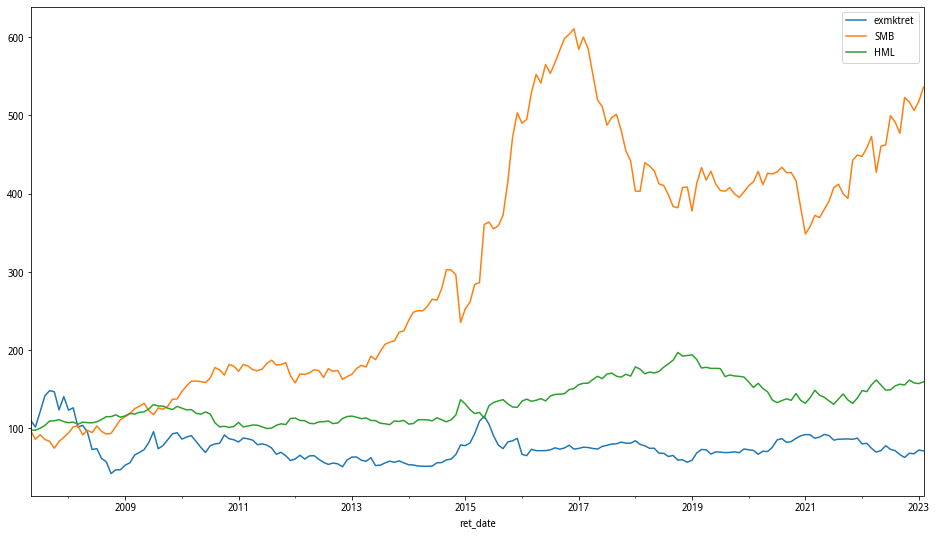

In [191]:
# index_info = DataAPI.SecIDGet(assetClass="IDX",pandas="1")

# 用中证800作为market return
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])
index_df['ret_date'] = index_df['tradeDate'].dt.to_period('M')

index_df.sort_values('tradeDate',inplace=True)
index_df = index_df.groupby('ret_date',as_index=False).last()
index_df['mktret'] = index_df['closeIndex'] / index_df['closeIndex'].shift() - 1

index_df = pd.merge(index_df,rf,left_on=['ret_date'],right_on=['ym'])
index_df['exmktret'] = index_df['mktret'] - index_df['rf']

index_df.drop(['ym','mktret','rf','indexID','secShortName','tradeDate',
               'closeIndex','CHGPct'],axis=1,inplace=True)

index_df.dropna(inplace=True)

factors_df = pd.merge(index_df, factors_df, on='ret_date')

factors_df['ret_date'] = factors_df['ret_date'].dt.to_timestamp(how='end').dt.normalize()

factors_df.set_index('ret_date',inplace=True)

((1 + factors_df).cumprod()*100).plot()

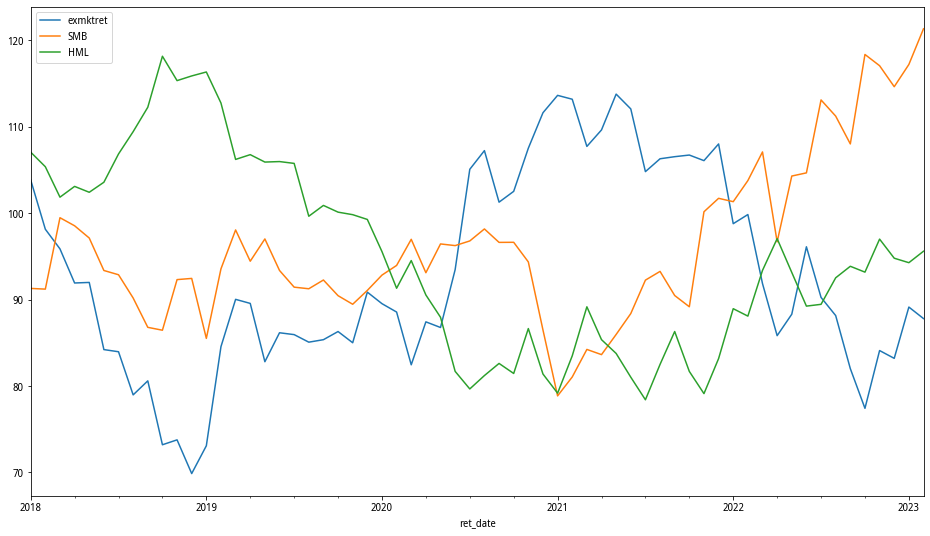

In [192]:
((1 + factors_df.loc['2018':]).cumprod()*100).plot()

In [193]:
factors_df

,exmktret,SMB,HML
ret_date,,,
2007-05-31,0.098693,-0.029050,-0.023142
2007-06-30,-0.074622,-0.115226,-0.001500
2007-07-31,0.192240,0.068276,0.025781
2007-08-31,0.167193,-0.066848,0.034985
2007-09-30,0.047263,-0.026022,0.054680
2007-10-31,-0.010382,-0.106058,0.003520
2007-11-30,-0.157389,0.116601,0.013235
2007-12-31,0.137366,0.062027,-0.022538
2008-01-31,-0.123254,0.064026,-0.013051


In [194]:
factors_df.to_csv('./output_data/factors/ff3.csv')

## Long-only factors

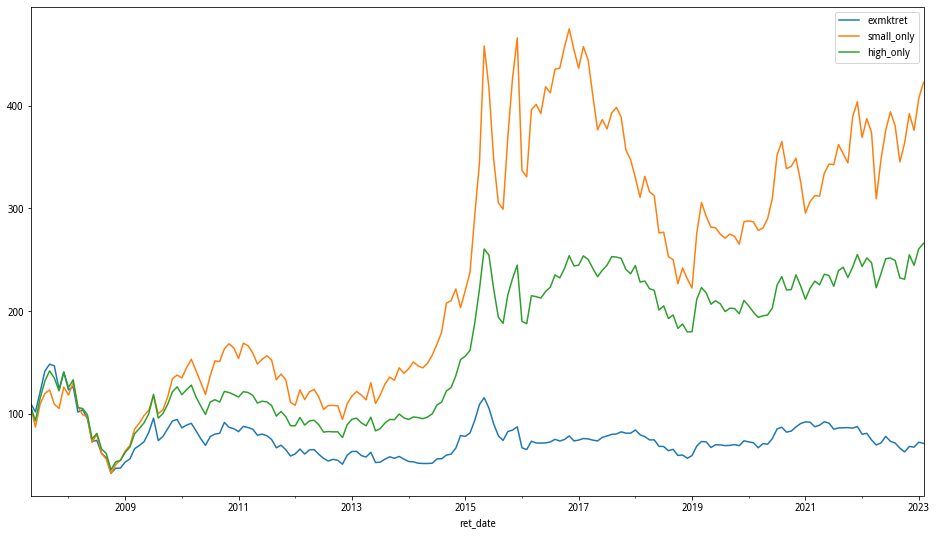

In [195]:
small_only = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 

high_only = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 

factors_long_df = pd.DataFrame(np.vstack([small_only,high_only])).T
factors_long_df.columns = ['small_only','high_only']
factors_long_df.index = small_only.index

factors_long_df = pd.merge(index_df, factors_long_df, on='ret_date')

factors_long_df['ret_date'] = factors_long_df['ret_date'].dt.to_timestamp(freq='day',how='end').dt.normalize()

factors_long_df.set_index('ret_date',inplace=True)

((1 + factors_long_df).cumprod()*100).plot()

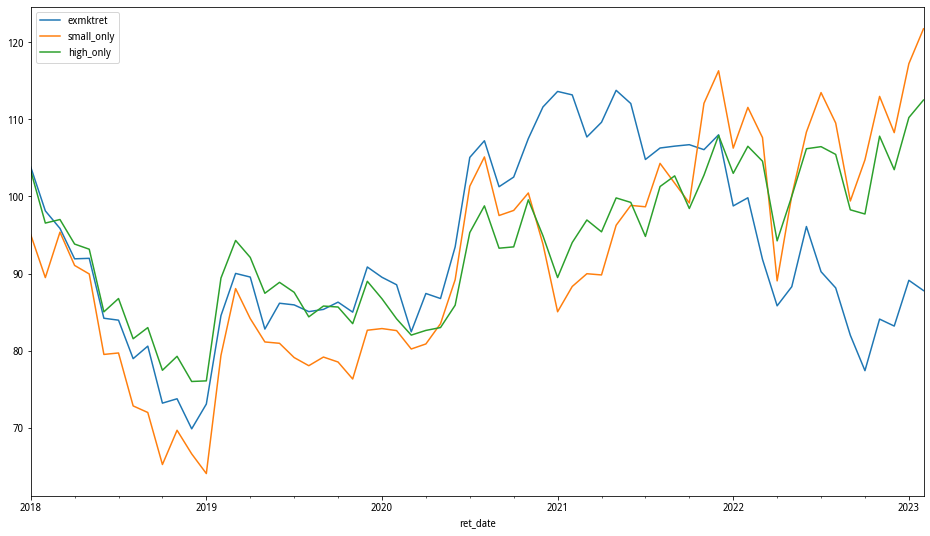

In [196]:
((1 + factors_long_df.loc['2018':]).cumprod()*100).plot()

In [197]:
factors_long_df

,exmktret,small_only,high_only
ret_date,,,
2007-05-31,0.098693,0.068583,0.068080
2007-06-30,-0.074622,-0.186779,-0.129264
2007-07-31,0.192240,0.257748,0.236593
2007-08-31,0.167193,0.094294,0.145350
2007-09-30,0.047263,0.029289,0.075538
2007-10-31,-0.010382,-0.112765,-0.049572
2007-11-30,-0.157389,-0.038236,-0.092364
2007-12-31,0.137366,0.198268,0.148977
2008-01-31,-0.123254,-0.061552,-0.105984


In [198]:
factors_long_df.to_csv('./output_data/factors/ff3_long_only.csv')